# STA218 Project
## 0.1 data preparation
### dataset introduction
The Data folder contains 2 data files:

1. paper_information.csv    -- the complete list of 5,746 papers including title, publisher, doi, abstract, keywords, references, paper_id  for each  from four journals (the detailed list is shown below). 

2. paper_edge_citation.csv    --the edges in the citation network for the node 'paper_id'. There are 23,737 edges, and each edge represents that 'source' cites 'target' once. Edges between papers are directed. 

Journals are listed as follows:

 [1] JOURNAL OF THE AMERICAN STATISTICAL ASSOCIATION                             
 [2] BIOMETRIKA                                                   
 [3] JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-STATISTICAL METHODOLOGY  
 [4] ANNALS OF STATISTICS

 We use abbreviation for each journal in the following analysis:  
    [1] JASA                             
    [2] Biometrika                                                  
    [3] J. R. Stat. Soc. B  
    [4] Ann. Stat

using to find the publishments status and citation network of authors in these four journals. 

In [1]:
import pandas as pd
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# --- 1. Configuration (配置层) ---
DATA_CONFIG = {
    'files': {
        'info': 'paper_information.csv',
        'edges': 'paper_edge_citation.csv'
    },
    'journal_mapping': {
        'JOURNAL OF THE AMERICAN STATISTICAL ASSOCIATION': 'JASA',
        'BIOMETRIKA': 'Biometrika',
        'JOURNAL OF THE ROYAL STATISTICAL SOCIETY SERIES B-STATISTICAL METHODOLOGY': 'J. R. Stat. Soc. B',
        'ANNALS OF STATISTICS': 'Ann. Stat'
    }
}

# --- 2. Functional Core (逻辑层) ---
def print_dataset_report(n_original, n_clean, n_removed, n_citations, journal_counts):
    """
    Prints a consolidated report of the dataset status.
    """
    print("\n" + "="*50)
    print("📊 DATASET PROCESSING REPORT")
    print("="*50)
    
    print("1. CLEANING SUMMARY")
    print(f"   • Original Papers:      {n_original:>6,}")
    print(f"   • Removed (Non-Big4):   {n_removed:>6,}")
    print(f"   • Final Papers (Nodes): {n_clean:>6,}")
    print("-" * 50)
    
    print("2. NETWORK STATISTICS")
    print(f"   • Total Citations (Edges): {n_citations:>6,}")
    print(f"   • Avg. Citations/Paper:    {n_citations/n_clean:>6.2f}")
    print("-" * 50)
    
    print("3. JOURNAL DISTRIBUTION")
    print(journal_counts.to_string())
    print("="*50 + "\n")

def find_missed_data(paper_info: pd.DataFrame) -> pd.DataFrame:
    """
    finds the row that have missed values in paper_info, preparing for completion
    """
    # Filter for missing DOI, Abstract, or References
    # 1. DOI is 'NO DOI' or NaN
    missing_doi = (paper_info['doi'] == 'NO DOI') | (paper_info['doi'].isna()) | (paper_info['doi'] == '')
    
    # 2. Abstract is 'no abstract' or NaN
    missing_abstract = (paper_info['abstract'] == 'no abstract') | (paper_info['abstract'].isna()) | (paper_info['abstract'] == '')
    
    # 3. References is empty string or NaN
    # Note: 'references' column contains the string of references
    missing_refs = (paper_info['references'].isna()) | (paper_info['references'] == '') | (paper_info['references'] == '[]') 
    
    # Combine conditions
    mask = missing_doi | missing_abstract | missing_refs
    
    return paper_info[mask].copy()

def load_and_filt_dataset(config: dict) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Loads raw data, filters for target journals, and standardizes names.
    Returns: (paper_info, paper_citations)
    """
    # A. Load
    print("⏳ Loading datasets...")
    raw_info = pd.read_csv(config['files']['info'])
    citations = pd.read_csv(config['files']['edges'])
    
    # B. Filter (The publisher)
    target_journals = config['journal_mapping'].keys()
    mask = raw_info['publisher'].isin(target_journals)
    clean_info = raw_info[mask].copy()
    
    # C. Transform
    clean_info['publisher'] = clean_info['publisher'].replace(config['journal_mapping'])
    
    # D. Report (Consolidated)
    '''
    print_dataset_report(
        n_original=len(raw_info),
        n_clean=len(clean_info),
        n_removed=len(raw_info) - len(clean_info),
        n_citations=len(citations),
        journal_counts=clean_info['publisher'].value_counts()
    )
    '''
    
    return clean_info, citations

# --- 3. Execution (执行层) ---
paper_info, paper_citations = load_and_filt_dataset(DATA_CONFIG)

# TODO: 为什么输出信息被打印了两次? missed doi 为什么是 in total = 215? 当时输出216才是对的啊? 还需要使用 unique() 筛选一遍
# 数据里面title还有不规范格式, 或者说多样化格式, doi号也有不全面的地方 
# 准备时序数据?

⏳ Loading datasets...


## 1.1 EDA 和 单变量分析

## 3. 数据质量评估计划 (Data Quality Assessment Plan)

我们将从以下维度对数据集进行严格的质量评估，以确保分析结果的可靠性。

| 评估维度 (Dimension) | 潜在问题 (Potential Issue) | 重要性 (Importance) | 解决方案/代码实现 (Solution/Code) |
| :--- | :--- | :--- | :--- |
| **1. 时间跨度 (Time Span)** | 某些年份的论文数量突然降为 0 (Sudden drops) | 指示数据缺失，影响趋势分析的连续性 | 绘制论文年份分布直方图 (`hist plot`)，检查断点。 |
| **2. 孤立节点 (Isolated Nodes)** | 存在大量入度=0 且 出度=0 的节点 | 暗示引文网络爬取不完整 (Incomplete crawling) | 计算孤立节点比例；若过高需重新审视数据源。 |
| **3. 作者歧义 (Author Ambiguity)** | 同名异人 (Homonyms, 如 "Wang, Y.") | 严重影响合作网络 (Collaboration Network) 分析 | 随机抽样常见姓名进行人工核对；尝试引入 OpenAlex ID。 |
| **4. 完整性 (Completeness)** | `authors`, `year`, `references` 字段存在空值；右删失 (Right-Censoring) | 基础数据完整性；近两年论文引用数天然偏低 | 统计缺失值比例 (`isnull().sum()`)；分析引用数时排除近 2 年数据。 |
| **5. 准确性 (Accuracy)** | DOI 格式错误；引用关系中的 Source/Target 在节点表中不存在 | 破坏网络拓扑结构的有效性 | 验证 DOI 格式；检查 Edge List 中的 ID 是否都在 Node List 中。 |
| **6. 一致性 (Consistency)** | 期刊名称拼写不一；年份格式混乱 | 导致分组聚合分析失效 | 标准化期刊名 (Mapping)；统一清洗年份格式。 |
| **7. 时效性 (Timeliness)** | 数据截止年份过早 | 降低分析结果的现实指导意义 | 检查数据集的最大年份 (`max(year)`)。 |

根据部分输出, 和简单概览, 我们发现数据质量总体较好, 但存在部分缺失 DOI 的情况, 同时缺少发表年份的数据, 我们计划使用 OpenAlex API 来补全这些缺失的信息。为后续时序分析, 网络分析和概念发展预测等任务打下坚实基础。

In [2]:
def print_quality_assessment(paper_info: pd.DataFrame, paper_citations: pd.DataFrame, author_file: str = "authors_output_openalex.csv"):
    """
    Prints a data quality assessment report including coverage, accuracy, and consistency checks.
    """
    print("=== Data Quality Assessment Report ===\n")

    # 3. Isolated Nodes (Coverage)
    all_nodes = set(paper_info['paper_id'])
    source_nodes = set(paper_citations['source'])
    target_nodes = set(paper_citations['target'])
    connected_nodes = source_nodes.union(target_nodes)
    isolated_nodes = all_nodes - connected_nodes
    isolation_rate = len(isolated_nodes) / len(all_nodes) if len(all_nodes) > 0 else 0

    print(f"3. [Coverage] Isolated Node Analysis:")
    print(f"   Total Papers: {len(all_nodes)}")
    print(f"   Isolated Papers: {len(isolated_nodes)} ({isolation_rate:.2%})")
    if isolation_rate > 0.1:
        print("   WARNING: High isolation rate (>10%). Citation network might be incomplete.")
    print("-" * 30)

    # 4. Accuracy (Citation Validity)
    # Check if edges connect to papers that don't exist in our paper_info
    invalid_sources = paper_citations[~paper_citations['source'].isin(all_nodes)]
    invalid_targets = paper_citations[~paper_citations['target'].isin(all_nodes)]

    print(f"4. [Accuracy] Citation Link Validity:")
    print(f"   Total Citations: {len(paper_citations)}")
    print(f"   Edges with unknown Source: {len(invalid_sources)}")
    print(f"   Edges with unknown Target: {len(invalid_targets)}")
    if len(invalid_targets) > 0:
        print("   Note: Unknown targets are common if the dataset only contains papers from specific journals, \n   but citations point to outside papers. If 'paper_edge_citation' is strictly internal, this is an error.")
    print("-" * 30)

    # 5. Author Ambiguity (Sample Check)
    if os.path.exists(author_file):
        print("5. [Consistency] Author Name Check (from crawled data):")
        try:
            auth_df = pd.read_csv(author_file)
            # Check for a common name
            sample_name = "Wang"
            if 'first_author' in auth_df.columns:
                wang_entries = auth_df[auth_df['first_author'].str.contains(sample_name, na=False, case=False)]
                print(f"   Entries containing '{sample_name}' in first_author: {len(wang_entries)}")
                if not auth_df['first_author'].dropna().empty:
                    print("   Sample of names (check for format consistency):")
                    print(auth_df['first_author'].dropna().sample(5).values)
            else:
                 print(f"   Column 'first_author' not found in {author_file}.")
        except Exception as e:
            print(f"   Could not read author file: {e}")
    else:
        print("5. [Consistency] Author data file not found. Skipping name ambiguity check.")

print_quality_assessment(paper_info, paper_citations)

=== Data Quality Assessment Report ===

3. [Coverage] Isolated Node Analysis:
   Total Papers: 5738
   Isolated Papers: 0 (0.00%)
------------------------------
4. [Accuracy] Citation Link Validity:
   Total Citations: 23737
   Edges with unknown Source: 21
   Edges with unknown Target: 7
   Note: Unknown targets are common if the dataset only contains papers from specific journals, 
   but citations point to outside papers. If 'paper_edge_citation' is strictly internal, this is an error.
------------------------------
5. [Consistency] Author data file not found. Skipping name ambiguity check.


## 1.1 OpenAlex 爬虫数据补全


In [3]:
import pandas as pd
import requests
import time
import os
from urllib.parse import quote

# --- 1. Crawler Configuration (配置层) ---
CRAWLER_CONFIG = {
    'api_base': "https://api.openalex.org/works",
    'headers': {
        "User-Agent": "CitationNetworkAnalysis/1.0 (mailto:12412903@mail.sustech.edu.cn)"
    },
    'files': {
        'doi_output': 'crawled_dois.csv',
        'details_output': 'crawled_details.csv'
    },
    'batch_size': 50,
    'timeout': 10,
    'sleep_interval': 0.1
}

# --- 2. Core Fetch Functions (原子功能层) ---
def fetch_doi_by_title(title: str) -> dict:
    """
    根据标题查找 DOI。
    Returns: {'title': ..., 'doi': ..., 'doi_status': ...}
    """
    if not title or len(str(title)) < 5:
        return {'title': title, 'doi': None, 'doi_status': 'skipped_short_title'}

    query = quote(str(title))
    url = f"{CRAWLER_CONFIG['api_base']}?search={query}&per-page=1"

    try:
        response = requests.get(url, headers=CRAWLER_CONFIG['headers'], timeout=CRAWLER_CONFIG['timeout'])
        if response.status_code == 200:
            results = response.json().get('results', [])
            if results:
                found_doi = results[0].get('doi')
                if found_doi:
                    clean_doi = found_doi.replace('https://doi.org/', '')
                    return {'title': title, 'doi': clean_doi, 'doi_status': 'found'}
                return {'title': title, 'doi': None, 'doi_status': 'missing_in_result'}
            return {'title': title, 'doi': None, 'doi_status': 'not_found'}
        return {'title': title, 'doi': None, 'doi_status': f'error_{response.status_code}'}
    except Exception as e:
        return {'title': title, 'doi': None, 'doi_status': f'error_{str(e)}'}

def fetch_details_by_doi(doi: str) -> dict:
    """
    根据 DOI 查找作者和年份。
    Returns: {'doi': ..., 'first_author': ..., 'year': ..., 'author_status': ..., 'year_status': ...}
    """
    clean_doi = str(doi).replace('https://doi.org/', '').strip()
    url = f"{CRAWLER_CONFIG['api_base']}/doi:{clean_doi}"
    
    result = {
        'doi': clean_doi,
        'first_author': None, 'middle_authors': None, 'last_author': None, 'corresponding_author': None,
        'year': None,
        'author_status': 'init', 'year_status': 'init'
    }

    try:
        response = requests.get(url, headers=CRAWLER_CONFIG['headers'], timeout=CRAWLER_CONFIG['timeout'])
        
        if response.status_code == 404:
            result['author_status'] = 'not_found'
            result['year_status'] = 'not_found'
            return result
            
        response.raise_for_status()
        data = response.json()
        
        # 1. Extract Year
        result['year'] = data.get('publication_year')
        result['year_status'] = 'success' if result['year'] else 'missing'
        
        # 2. Extract Authors
        authorships = data.get('authorships', [])
        if not authorships:
            result['author_status'] = 'missing'
        else:
            middle_authors = []
            corresponding_authors = []
            
            for authorship in authorships:
                display_name = authorship.get('author', {}).get('display_name', '')
                position = authorship.get('author_position')
                
                if position == 'first':
                    result['first_author'] = display_name
                elif position == 'last':
                    result['last_author'] = display_name
                else:
                    middle_authors.append(display_name)
                    
                if authorship.get('is_corresponding'):
                    corresponding_authors.append(display_name)
            
            result['middle_authors'] = "; ".join(middle_authors)
            result['corresponding_author'] = "; ".join(corresponding_authors)
            result['author_status'] = 'success'
            
        return result

    except Exception as e:
        result['author_status'] = f'error_{str(e)}'
        result['year_status'] = f'error_{str(e)}'
        return result

# --- 3. Batch Processing Logic (业务逻辑层) ---
def _append_to_csv(data_list, filename):
    if not data_list: return
    df = pd.DataFrame(data_list)
    mode = 'a' if os.path.exists(filename) else 'w'
    header = not os.path.exists(filename)
    df.to_csv(filename, mode=mode, header=header, index=False)

def crawl_missing_dois(df: pd.DataFrame, output_file: str = CRAWLER_CONFIG['files']['doi_output']):
    """
    任务1: 根据 Title 补全 DOI
    """
    # 1. 确定待处理数据
    # 假设 df 包含 'title' 列。我们只处理 df 中传入的行 (通常是 missing DOI 的行)
    target_titles = df['title'].unique()
    
    # 2. 断点续传: 读取已存在的 output_file
    processed_titles = set()
    if os.path.exists(output_file):
        try:
            existing = pd.read_csv(output_file)
            if 'title' in existing.columns:
                processed_titles = set(existing['title'].unique())
        except: pass
    
    to_process = [t for t in target_titles if t not in processed_titles]
    print(f"[DOI Crawler] Total: {len(target_titles)}, Processed: {len(processed_titles)}, Pending: {len(to_process)}")
    
    # 3. 循环爬取
    buffer = []
    for i, title in enumerate(to_process):
        res = fetch_doi_by_title(title)
        buffer.append(res)
        
        if len(buffer) >= CRAWLER_CONFIG['batch_size']:
            _append_to_csv(buffer, output_file)
            print(f"   Saved {i+1}/{len(to_process)}...")
            buffer = []
        
        time.sleep(CRAWLER_CONFIG['sleep_interval'])
        
    if buffer:
        _append_to_csv(buffer, output_file)
    print("[DOI Crawler] Done.")

def crawl_paper_details(df: pd.DataFrame, output_file: str = CRAWLER_CONFIG['files']['details_output']):
    """
    任务2: 根据 DOI 补全 Author 和 Year
    """
    # 1. 确定待处理数据 (必须有 DOI)
    # 过滤掉无效 DOI
    valid_dois = df[~df['doi'].isna() & (df['doi'] != 'NO DOI')]['doi'].unique()
    
    # 2. 断点续传
    processed_dois = set()
    if os.path.exists(output_file):
        try:
            existing = pd.read_csv(output_file)
            # 兼容带前缀和不带前缀的比较
            processed_dois = set(existing['doi'].apply(lambda x: str(x).replace('https://doi.org/', '').strip()).unique())
        except: pass
        
    to_process = [d for d in valid_dois if str(d).replace('https://doi.org/', '').strip() not in processed_dois]
    print(f"[Details Crawler] Total: {len(valid_dois)}, Processed: {len(processed_dois)}, Pending: {len(to_process)}")
    
    # 3. 循环爬取
    buffer = []
    for i, doi in enumerate(to_process):
        res = fetch_details_by_doi(doi)
        buffer.append(res)
        
        if len(buffer) >= CRAWLER_CONFIG['batch_size']:
            _append_to_csv(buffer, output_file)
            print(f"   Saved {i+1}/{len(to_process)}...")
            buffer = []
            
        time.sleep(CRAWLER_CONFIG['sleep_interval'])
        
    if buffer:
        _append_to_csv(buffer, output_file)
    print("[Details Crawler] Done.")

In [4]:
# --- Execution Example ---

# 1. 准备数据
# 假设 paper_info 已经加载
# 找出缺失 DOI 的数据进行补全
missing_data = find_missed_data(paper_info)
missing_doi_df = missing_data[ (missing_data['doi'] == 'NO DOI') | (missing_data['doi'].isna()) ]

# print("Task 1: Crawling Missing DOIs...")
# crawl_missing_dois(missing_doi_df)

# 2. 爬取详细信息 (Author, Year)
# 对所有有 DOI 的论文进行爬取 (或者只针对缺失年份/作者的)
# 这里演示对所有 paper_info 中的有效 DOI 进行爬取
print("\nTask 2: Crawling Paper Details (Authors & Year)...")
crawl_paper_details(paper_info)

# 3. (Optional) Merge back to main DataFrame
# 这一步通常在分析前做，这里仅展示爬取过程


Task 2: Crawling Paper Details (Authors & Year)...
[Details Crawler] Total: 5521, Processed: 5521, Pending: 0
[Details Crawler] Done.


## 数据可视化
接下来, 通过各种图表, 展示一些总体情况.
1. 

📊 Preparing visualization data...


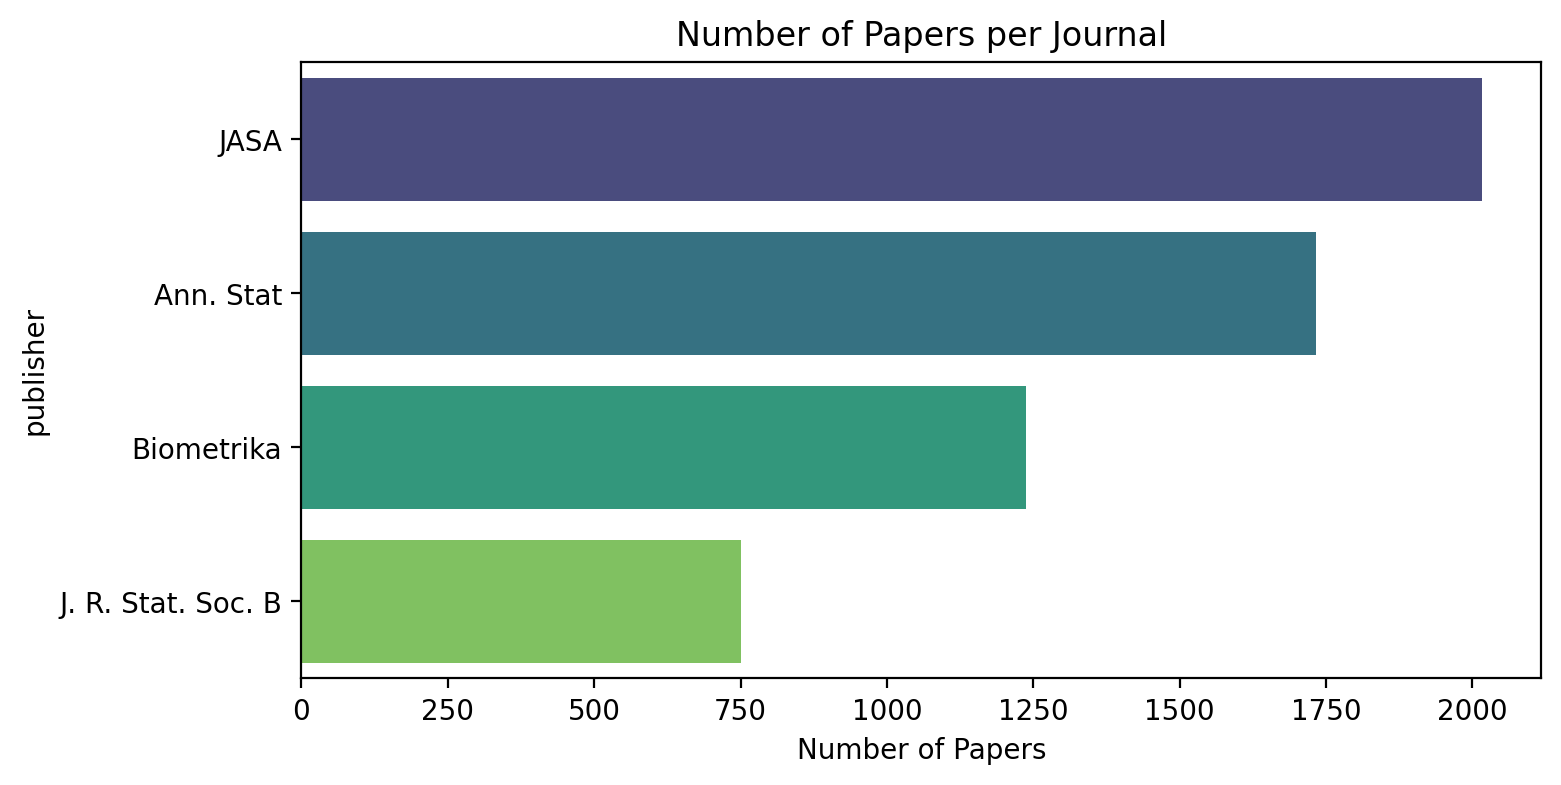

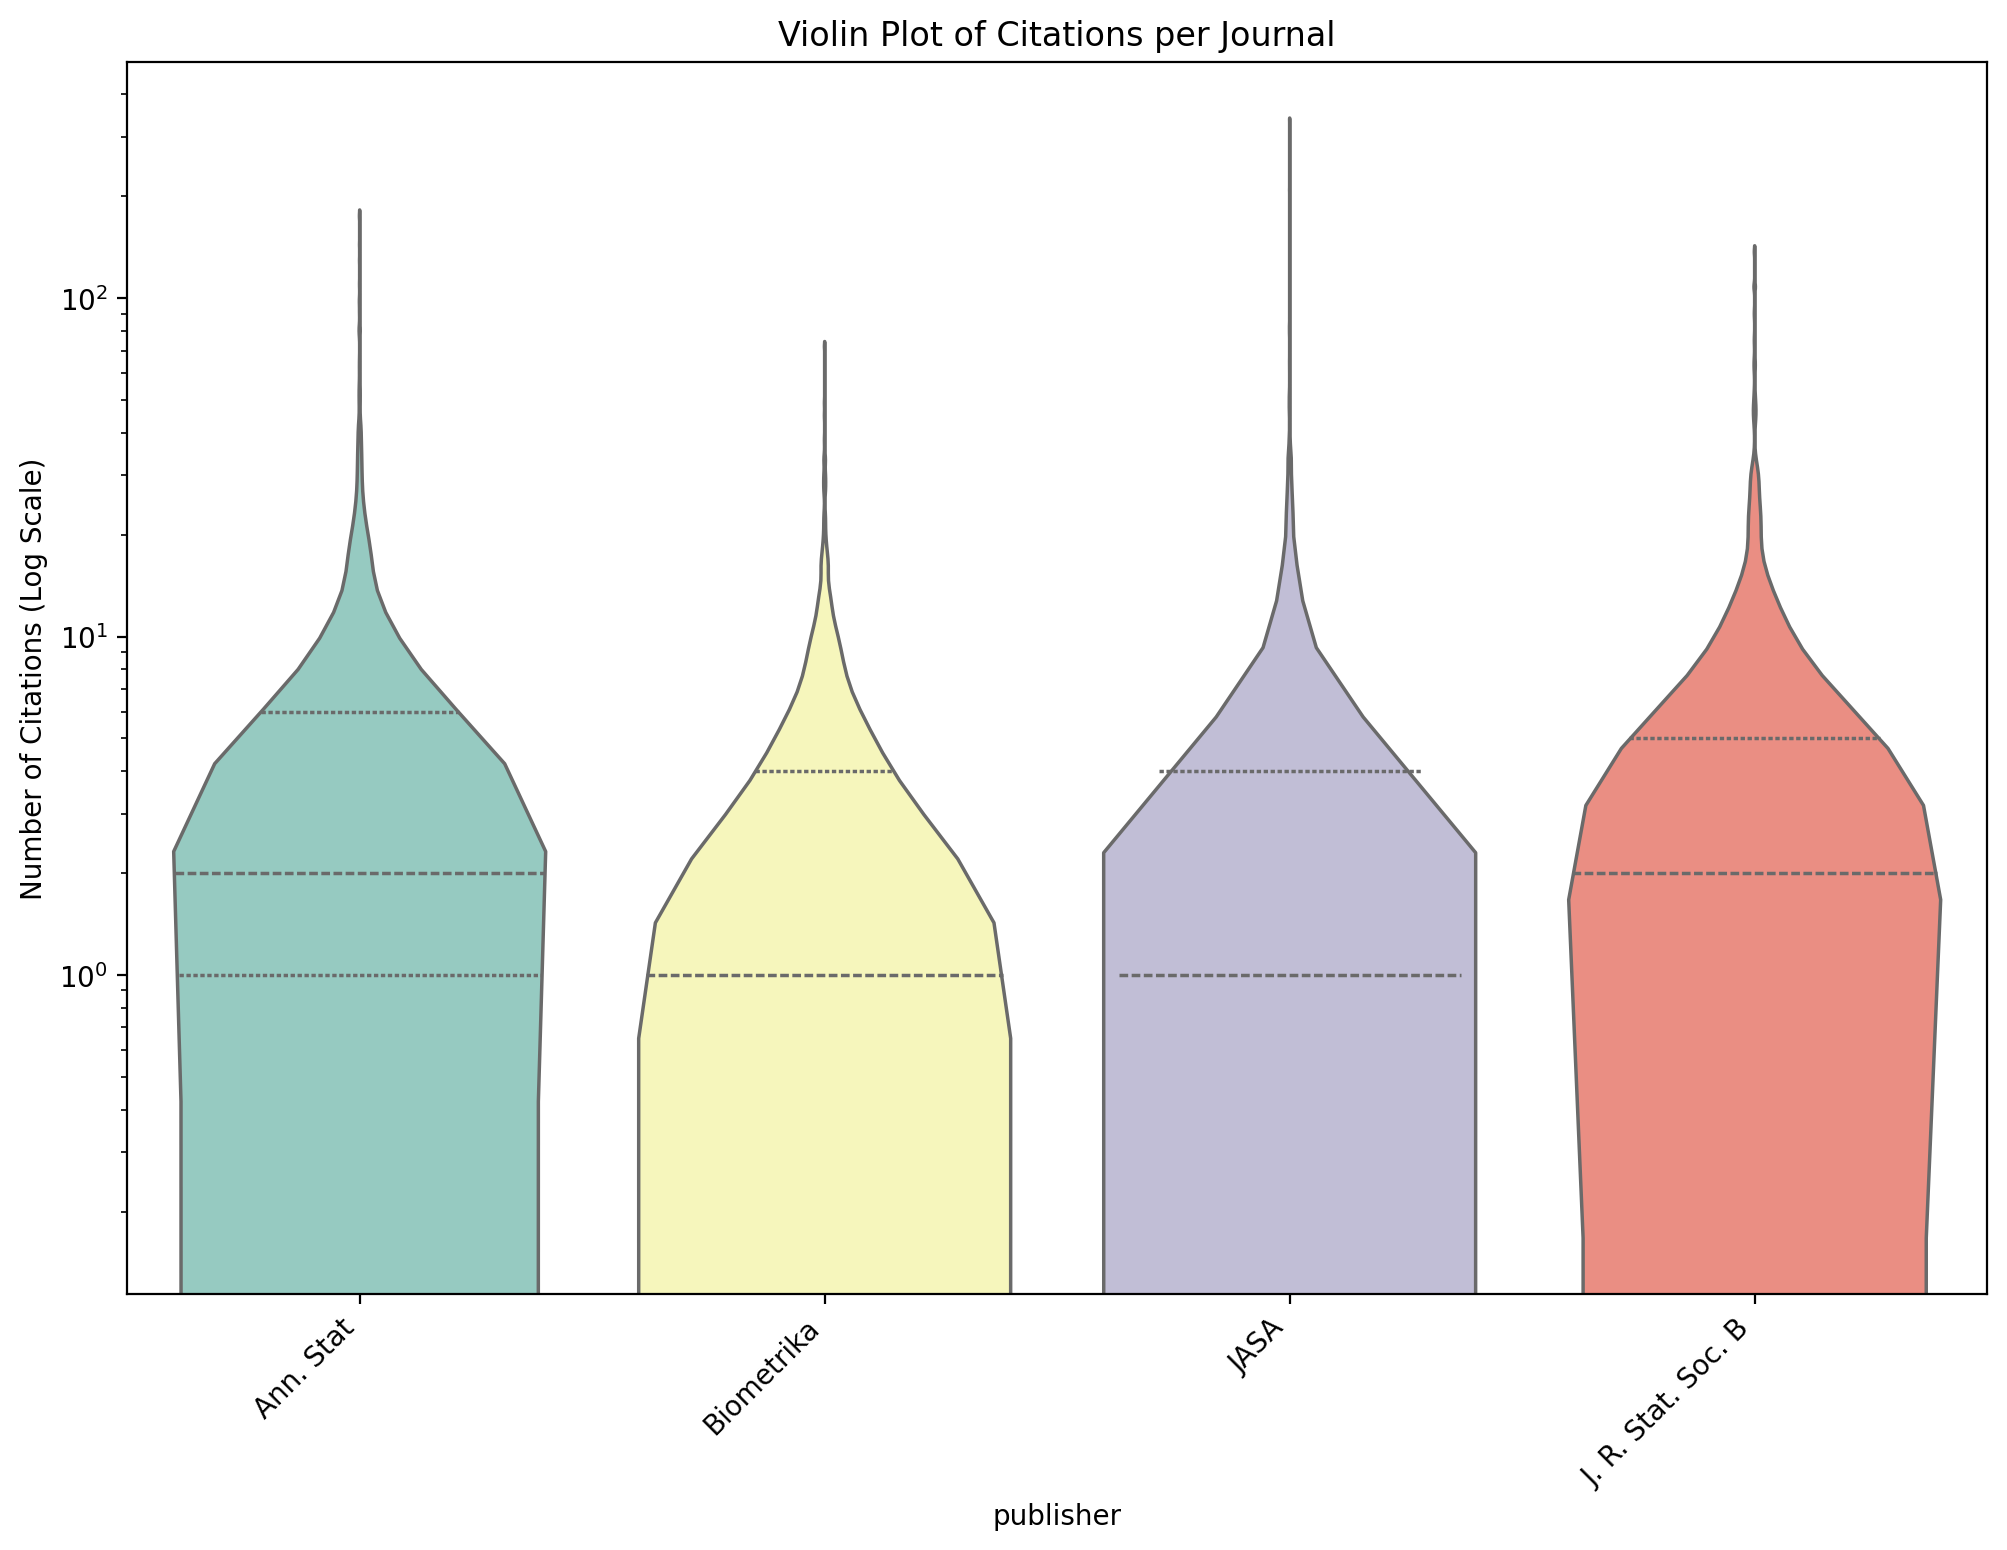

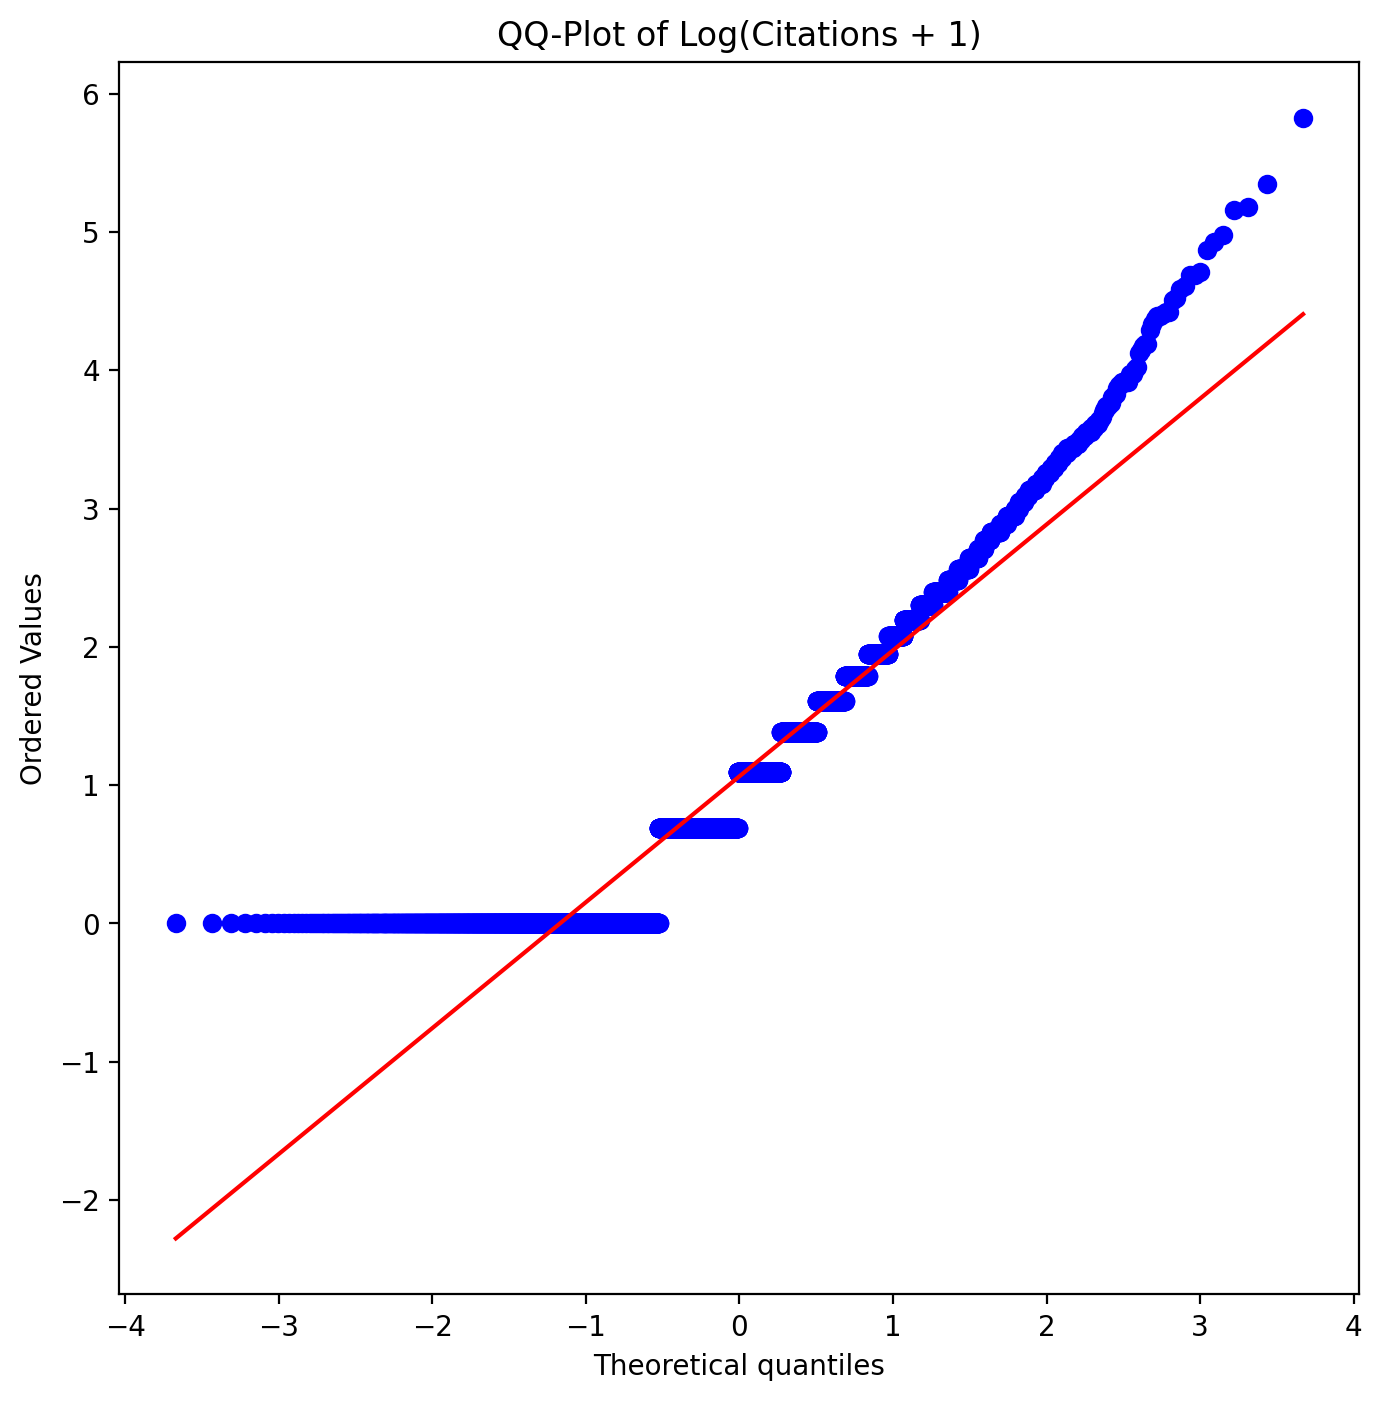

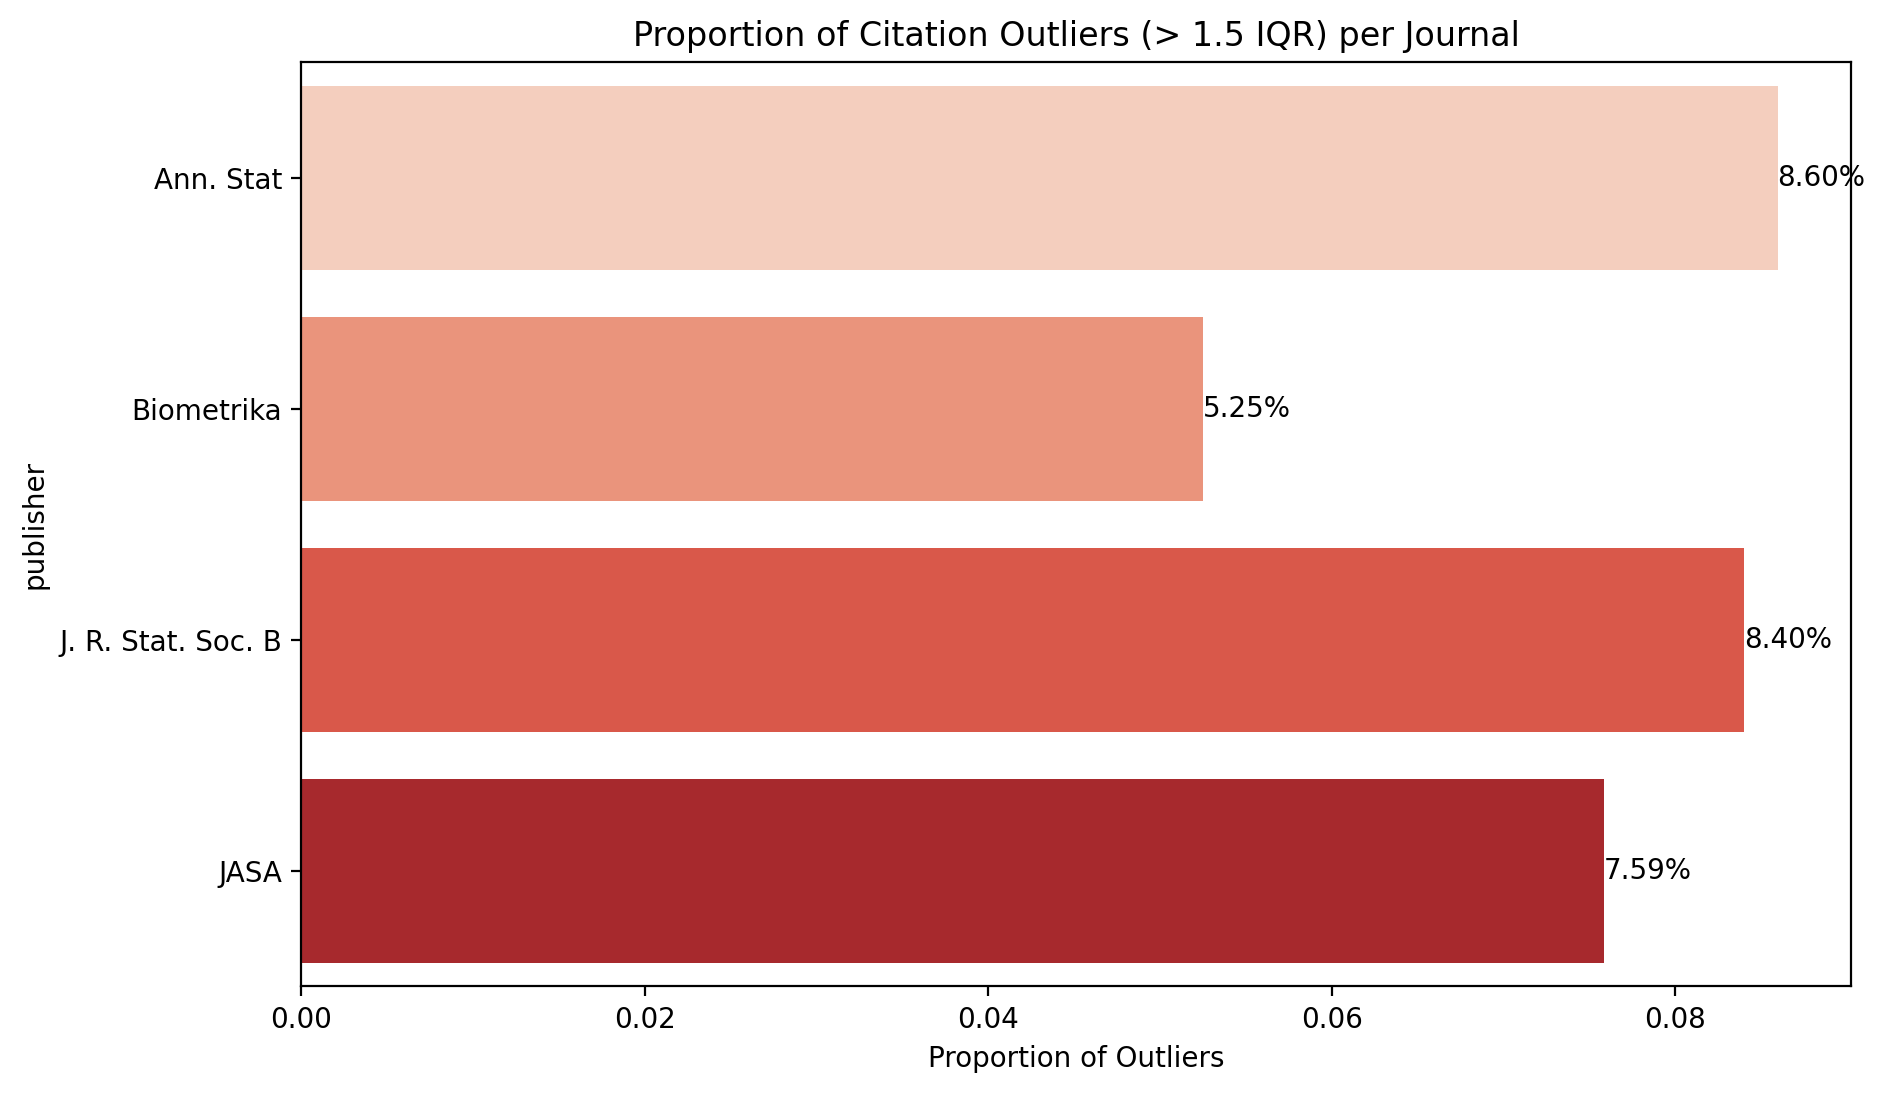

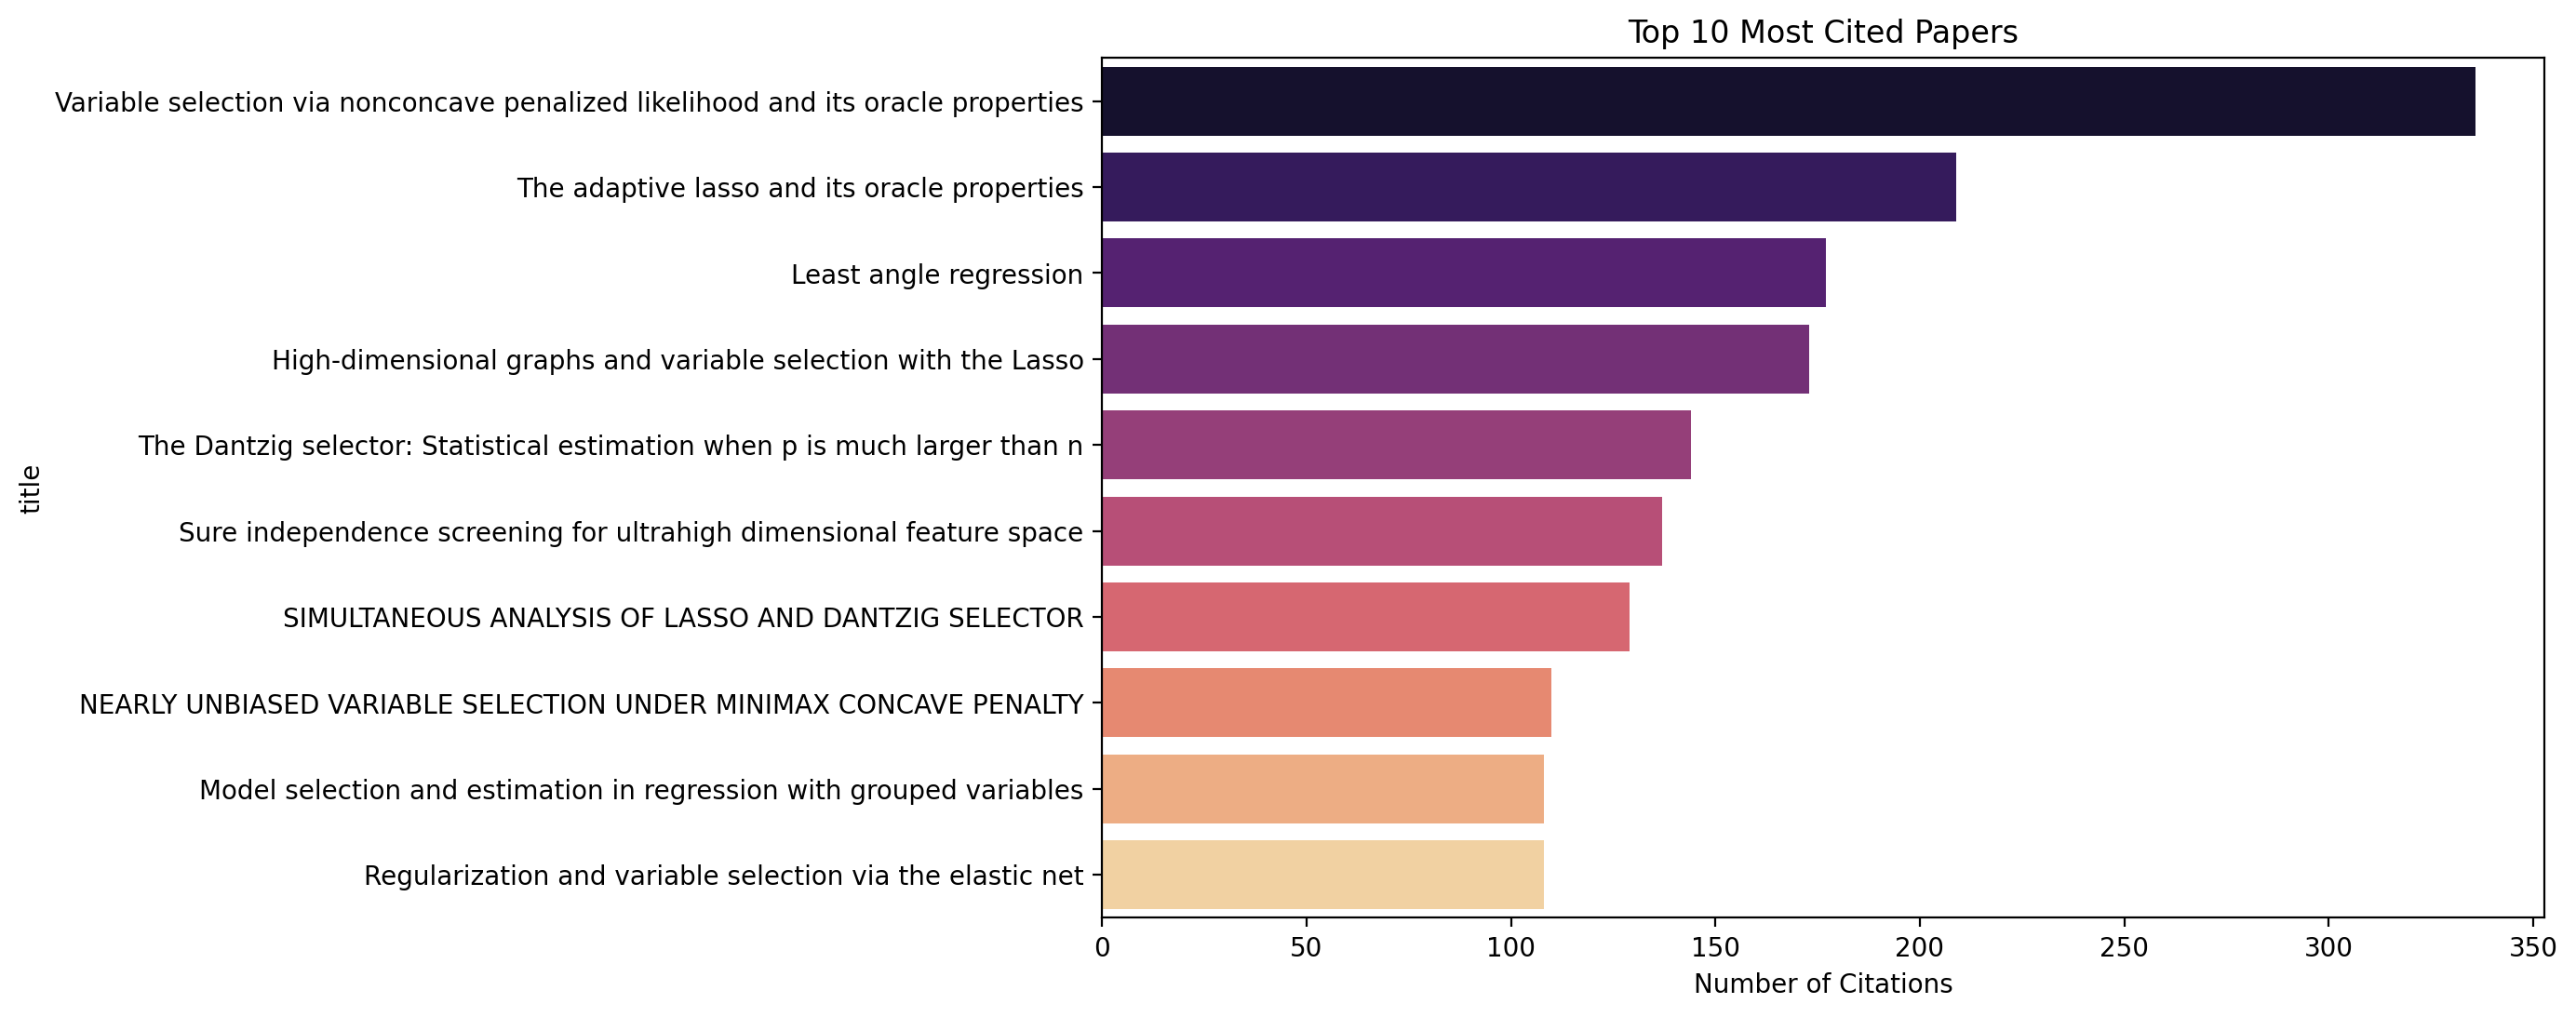

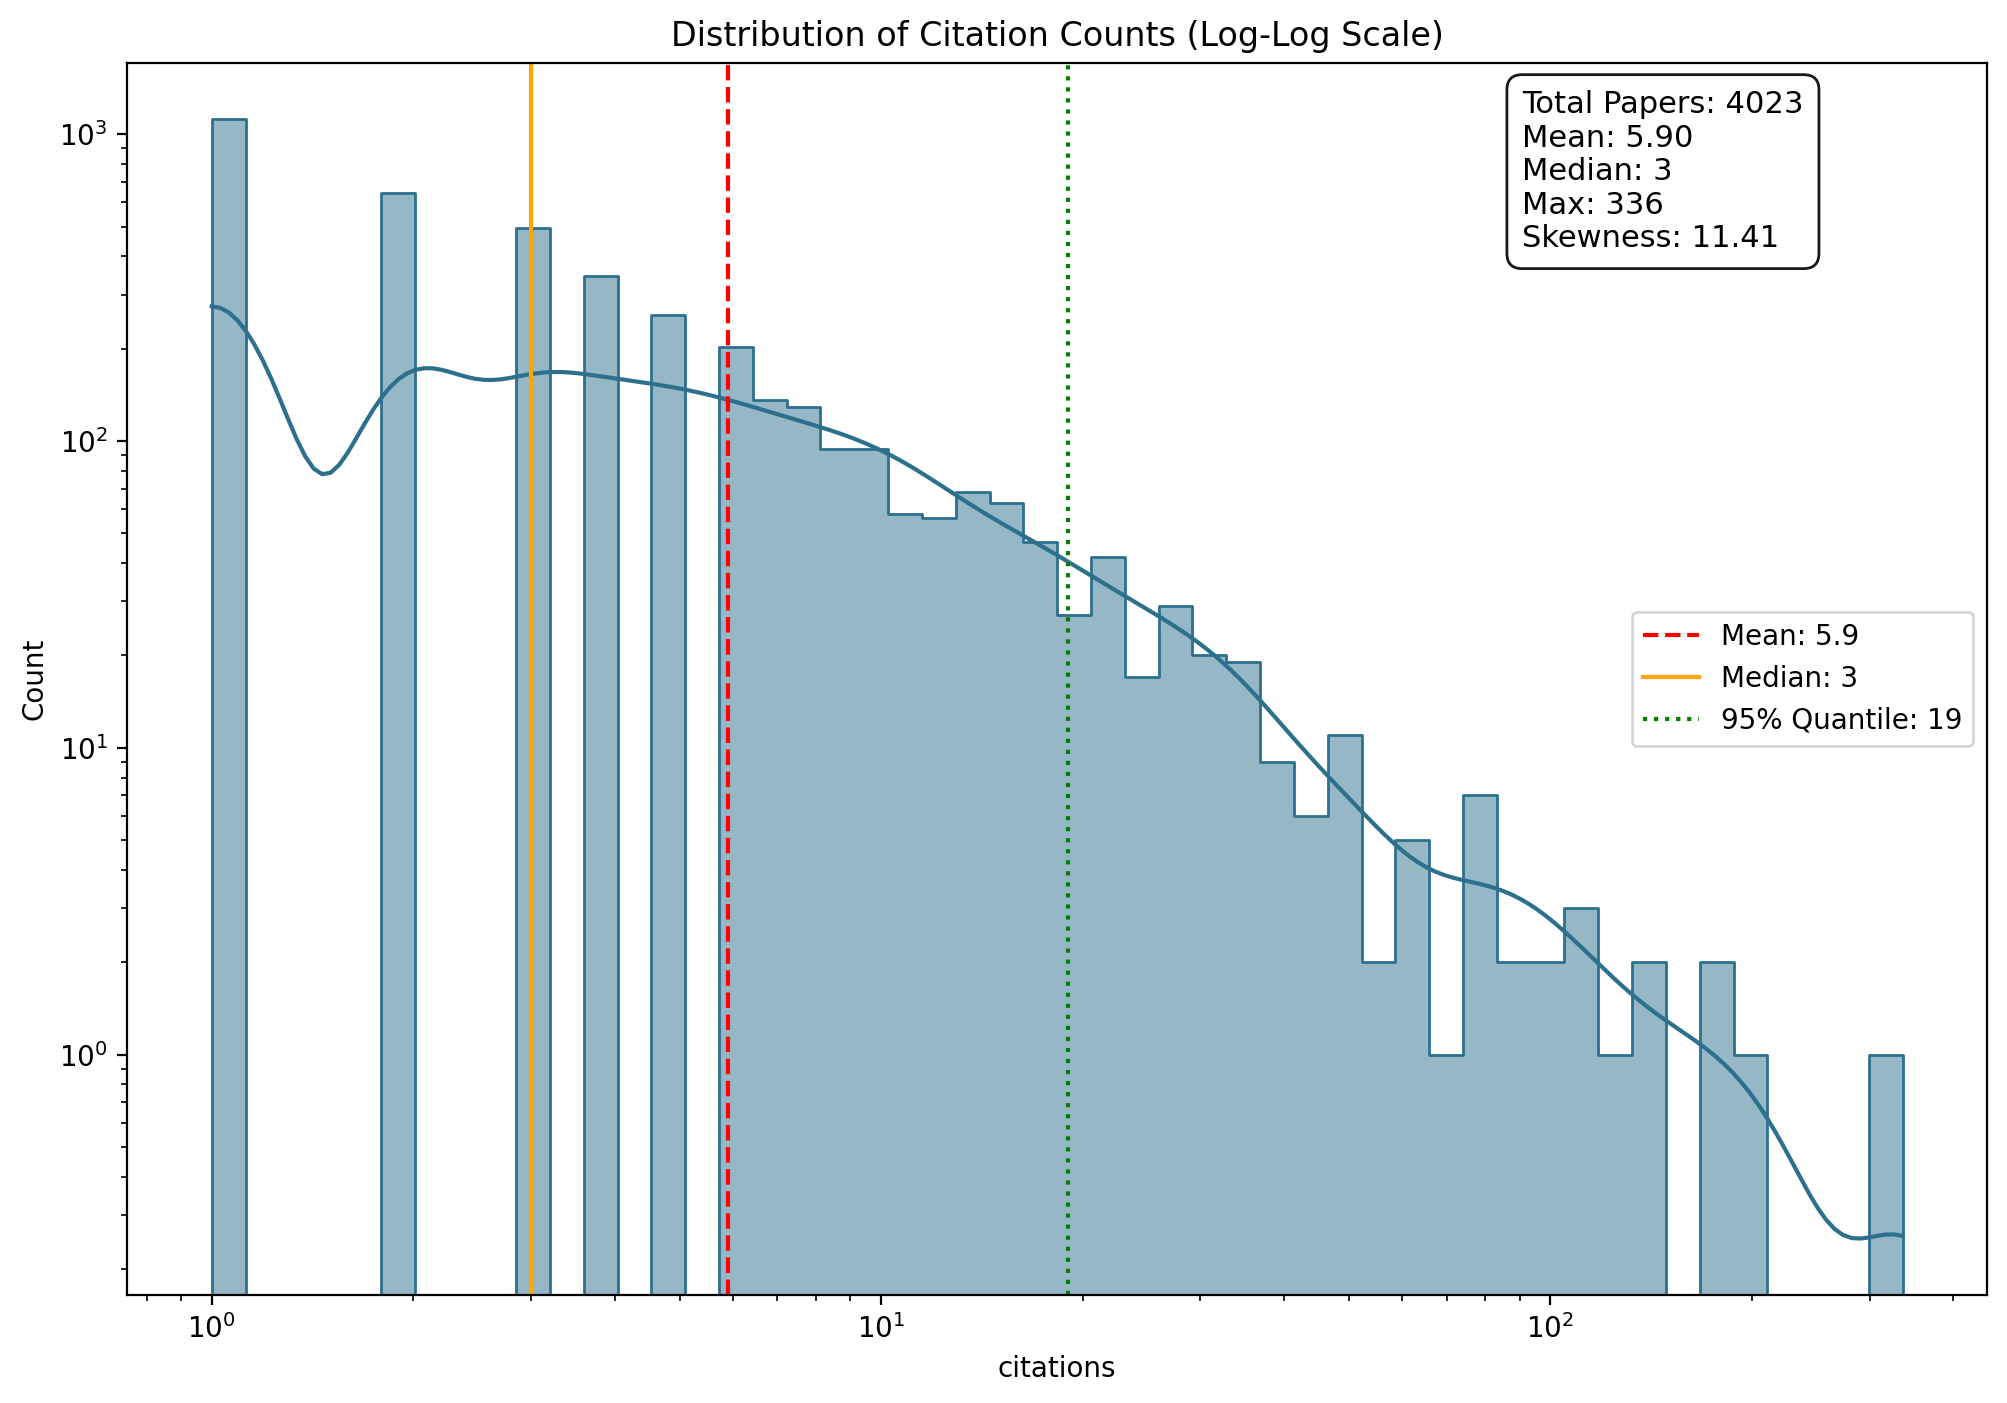

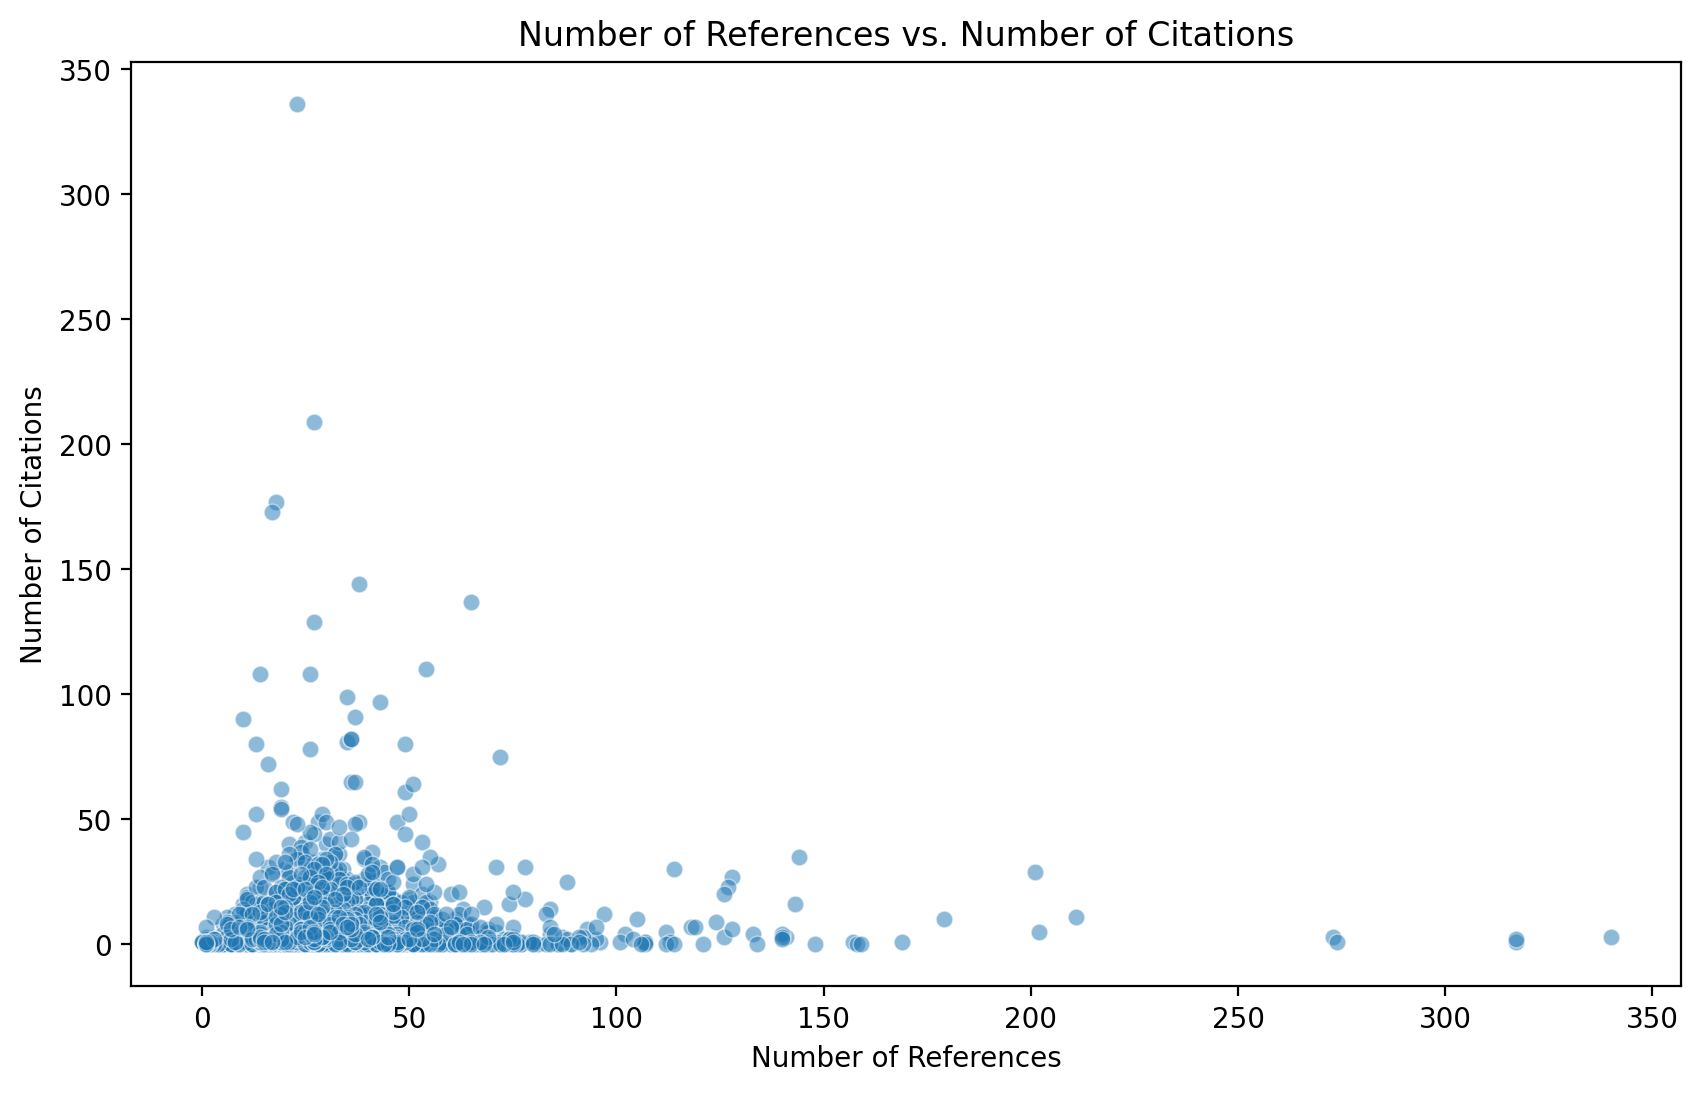

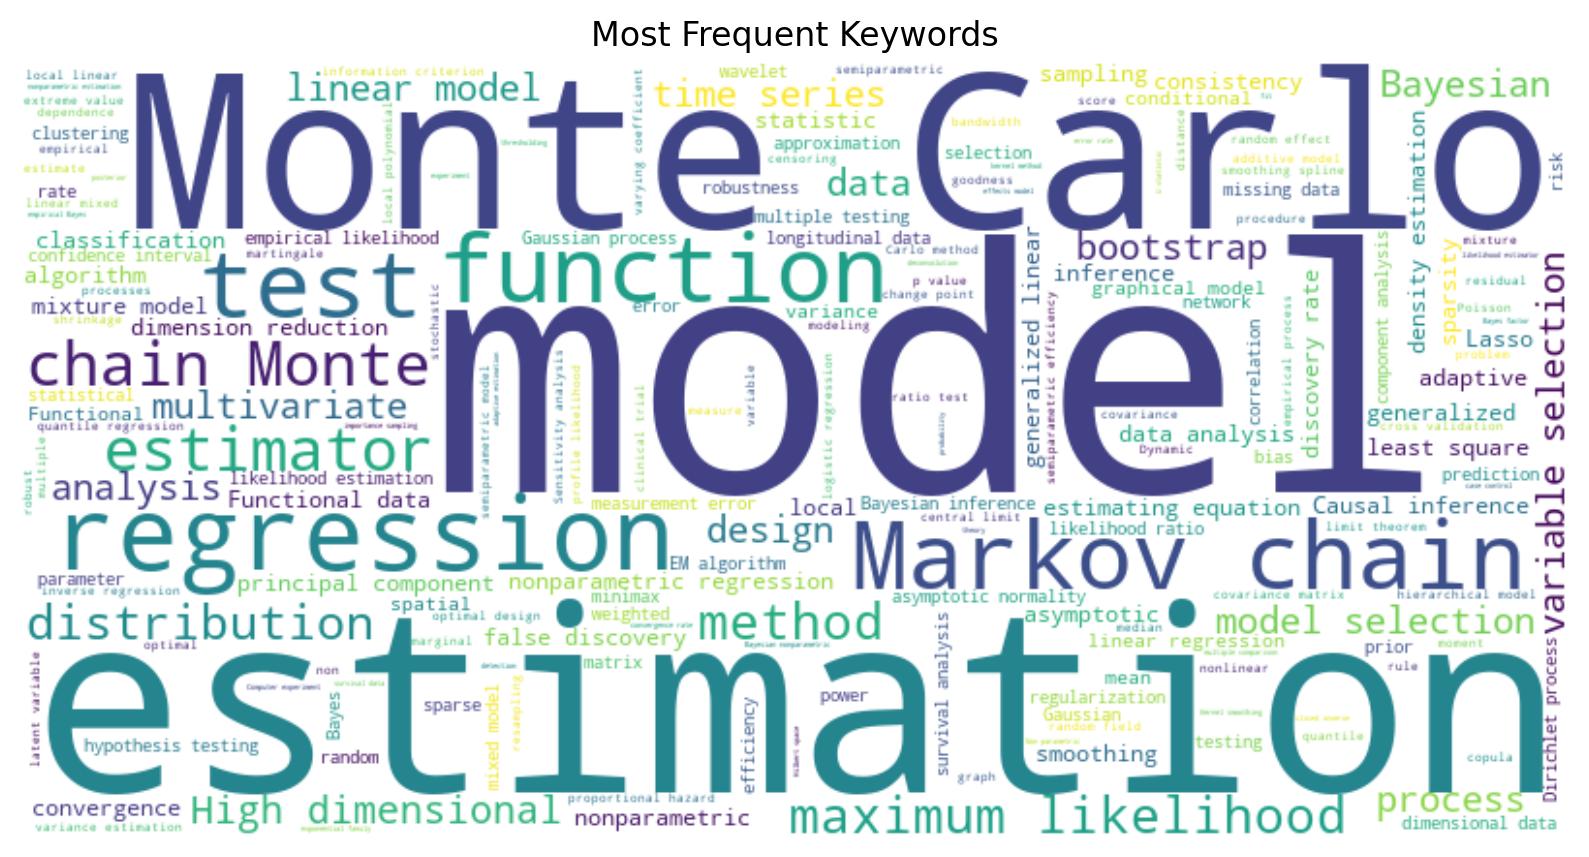

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from wordcloud import WordCloud

# --- 1. Visualization Configuration (配置层) ---
VIS_CONFIG = {
    'palette': 'viridis',
    'palette_outlier': 'Reds',
    'palette_top': 'magma',
    'figsize_large': (12, 8),
    'figsize_medium': (10, 6),
    'figsize_small': (8, 4),
    'log_scale': True
}

# --- 2. Data Preparation Utilities (工具层) ---
def calculate_gini(x):
    """Calculates Gini coefficient for a sequence of numbers."""
    if len(x) == 0: return 0
    mean_x = np.mean(x)
    if mean_x == 0: return 0
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * mean_x)

def count_refs(ref_string):
    """Counts number of references in the string."""
    if pd.isna(ref_string): return 0
    return len(str(ref_string).split('::'))

def get_outlier_stats(group):
    """Calculates outlier statistics for a group."""
    citations = group['citations']
    Q1 = citations.quantile(0.25)
    Q3 = citations.quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_count = len(citations[citations > upper_bound])
    total_count = len(citations)
    return pd.Series({
        'outlier_ratio': outliers_count / total_count,
        'outlier_count': outliers_count,
        'total_count': total_count
    })

def prepare_visualization_data(paper_info: pd.DataFrame, paper_citations: pd.DataFrame) -> dict:
    """
    Prepares all necessary datasets for visualization.
    Returns a dictionary containing processed dataframes and stats.
    """
    print("📊 Preparing visualization data...")
    data = {}
    
    # 1. Citation Counts
    citation_counts = paper_citations['target'].value_counts().reset_index()
    citation_counts.columns = ['paper_id', 'citations']
    data['citation_counts'] = citation_counts
    
    # 2. Merged Paper Data (Info + Citations)
    paper_data = paper_info.copy()
    paper_data = paper_data.merge(citation_counts, on='paper_id', how='left')
    paper_data['citations'] = paper_data['citations'].fillna(0)
    paper_data['ref_count'] = paper_data['references'].apply(count_refs)
    data['paper_data'] = paper_data
    
    # 3. Outlier Stats
    data['outlier_stats'] = paper_data.groupby('publisher')[['citations']].apply(get_outlier_stats).reset_index()
    
    # 4. Top Cited Papers
    data['top_cited'] = citation_counts.head(10).merge(paper_info[['paper_id', 'title']], on='paper_id', how='left')
    
    # 5. Gini over Time
    if 'year' in paper_data.columns:
        data['gini_per_year'] = paper_data.groupby('year')['citations'].apply(
            lambda x: calculate_gini(x.values) if len(x) > 1 else 0
        ).reset_index()
    
    # 6. Keywords
    data['all_keywords'] = paper_info['keywords'].dropna().str.cat(sep=',')
    
    return data

# --- 3. Plotting Functions (绘图层) ---
def plot_journal_distribution(paper_info, config):
    plt.figure(figsize=config['figsize_small'])
    journal_counts = paper_info['publisher'].value_counts()
    sns.barplot(x=journal_counts.values, y=journal_counts.index, hue=journal_counts.index, legend=False, palette=config['palette'])
    plt.title('Number of Papers per Journal')
    plt.xlabel('Number of Papers')
    plt.show()

def plot_citation_violin(paper_data, config):
    plt.figure(figsize=config['figsize_large'])
    sns.violinplot(x='publisher', y='citations', data=paper_data, hue='publisher', legend=False, palette='Set3', inner='quartile')
    if config['log_scale']:
        plt.yscale('log')
        plt.ylabel('Number of Citations (Log Scale)')
    else:
        plt.ylabel('Number of Citations')
    plt.title('Violin Plot of Citations per Journal')
    plt.xticks(rotation=45, ha='right')
    plt.show()

def plot_citation_qq(paper_data, config):
    citations_log = np.log1p(paper_data['citations'])
    plt.figure(figsize=(8, 8))
    stats.probplot(citations_log, dist="norm", plot=plt)
    plt.title('QQ-Plot of Log(Citations + 1)')
    plt.show()

def plot_outlier_proportion(outlier_stats, config):
    plt.figure(figsize=config['figsize_medium'])
    sns.barplot(x='outlier_ratio', y='publisher', data=outlier_stats, hue='publisher', legend=False, palette=config['palette_outlier'])
    plt.title('Proportion of Citation Outliers (> 1.5 IQR) per Journal')
    plt.xlabel('Proportion of Outliers')
    for index, row in outlier_stats.iterrows():
        plt.text(row['outlier_ratio'], index, f"{row['outlier_ratio']:.2%}", va='center')
    plt.show()

def plot_top_cited(top_cited, config):
    plt.figure(figsize=config['figsize_medium'])
    sns.barplot(x='citations', y='title', data=top_cited, hue='title', legend=False, palette=config['palette_top'])
    plt.title('Top 10 Most Cited Papers')
    plt.xlabel('Number of Citations')
    plt.show()

def plot_citation_distribution(citation_counts, config):
    plt.figure(figsize=config['figsize_large'])
    
    # Stats
    citations = citation_counts['citations']
    mean_val = citations.mean()
    median_val = citations.median()
    q95_val = citations.quantile(0.95)
    
    # Plot
    palette_color = sns.color_palette(config['palette'], 10)[3]
    sns.histplot(citations, bins=50, kde=True, color=palette_color, log_scale=config['log_scale'], element="step")
    
    # Lines
    plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.1f}')
    plt.axvline(median_val, color='orange', linestyle='-', label=f'Median: {median_val:.0f}')
    plt.axvline(q95_val, color='green', linestyle=':', label=f'95% Quantile: {q95_val:.0f}')
    
    # Text Box
    stats_text = (f"Total Papers: {len(citations)}\n"
                  f"Mean: {mean_val:.2f}\n"
                  f"Median: {median_val:.0f}\n"
                  f"Max: {citations.max()}\n"
                  f"Skewness: {citations.skew():.2f}")
    plt.gca().text(0.75, 0.85, stats_text, transform=plt.gca().transAxes, 
                   fontsize=11, bbox=dict(facecolor='white', alpha=0.9, boxstyle='round,pad=0.5'))
    
    plt.title('Distribution of Citation Counts (Log-Log Scale)')
    plt.yscale('log')
    plt.legend()
    plt.show()

def plot_refs_vs_citations(paper_data, config):
    plt.figure(figsize=config['figsize_medium'])
    sns.scatterplot(x='ref_count', y='citations', data=paper_data, alpha=0.5)
    plt.title('Number of References vs. Number of Citations')
    plt.xlabel('Number of References')
    plt.ylabel('Number of Citations')
    plt.show()

def plot_gini_over_time(gini_per_year, config):
    if gini_per_year is None: return
    plt.figure(figsize=config['figsize_large'])
    sns.lineplot(x='year', y='citations', data=gini_per_year, marker='o')
    plt.title('Concentration of Citations over Time (Gini Coefficient)')
    plt.xlabel('Year')
    plt.ylabel('Gini Coefficient')
    plt.grid(True)
    plt.show()

def plot_wordcloud(all_keywords, config):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)
    plt.figure(figsize=config['figsize_medium'])
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Most Frequent Keywords')
    plt.show()

# --- 4. Execution (执行层) ---
# Prepare Data
viz_data = prepare_visualization_data(paper_info, paper_citations)

# Execute Plots
plot_journal_distribution(paper_info, VIS_CONFIG)
plot_citation_violin(viz_data['paper_data'], VIS_CONFIG)
plot_citation_qq(viz_data['paper_data'], VIS_CONFIG)
plot_outlier_proportion(viz_data['outlier_stats'], VIS_CONFIG)
plot_top_cited(viz_data['top_cited'], VIS_CONFIG)
plot_citation_distribution(viz_data['citation_counts'], VIS_CONFIG)
plot_refs_vs_citations(viz_data['paper_data'], VIS_CONFIG)
if 'gini_per_year' in viz_data:
    plot_gini_over_time(viz_data['gini_per_year'], VIS_CONFIG)
plot_wordcloud(viz_data['all_keywords'], VIS_CONFIG)

In [ ]:
'''2.2.5 Temporal Concentration of Citations
Line plot showing the Gini coefficient of citations over time (where year data is available). This
tracks how unequal citation distributions are across years, indicating whether citation concentration
has increased or decreased over the study period'''

### Further Analysis on Top 10 Papers
We can further explore the characteristics of these top 10 papers with the following questions:
1. **Composition of Citing Journals**: Which journals cite these top papers the most? Is the impact confined to their own journal or cross-journal?
2. **Influence Reach (Direct & Indirect)**: What proportion of the entire dataset has directly or indirectly (2nd degree) cited these papers?
3. **Internal Connectivity**: Do these top 10 papers cite each other? Do they form a "rich club"?

In [6]:
# Analysis of Top 10 Papers: Journal Composition, Reach, and Internal Connectivity
import networkx as nx

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Data Prep: Ensure we have the IDs and Titles
top_10_ids = top_cited['paper_id'].tolist()
# Create a short title map for plotting
top_10_titles = dict(zip(top_cited['paper_id'], top_cited['title'].str[:15] + '...')) 

# --- Plot 1: Citing Journal Composition (Stacked Bar) ---
# Get all citations pointing to Top 10
direct_citations = paper_citations[paper_citations['target'].isin(top_10_ids)]
# Join to get the publisher of the CITING paper (source)
direct_citations_info = direct_citations.merge(paper_info[['paper_id', 'publisher']], left_on='source', right_on='paper_id', how='inner')

# Pivot: Rows=Target Paper, Cols=Citing Journal
journal_breakdown = direct_citations_info.groupby(['target', 'publisher']).size().unstack(fill_value=0)
# Rename index to titles
journal_breakdown.index = journal_breakdown.index.map(top_10_titles)

journal_breakdown.plot(kind='bar', stacked=True, ax=axes[0], colormap='viridis')
axes[0].set_title('Q1: Citing Journal Composition')
axes[0].set_xlabel('Top 10 Papers')
axes[0].set_ylabel('Number of Citations')
axes[0].legend(title='Citing Journal', bbox_to_anchor=(1.0, 1.0))


# --- Plot 2: Influence Reach (Pie Chart) ---
# Level 1: Papers directly citing Top 10
level_1_citers = set(direct_citations['source'].unique())

# Level 2: Papers citing Level 1 papers
# Find citations where target is in Level 1
level_2_citations = paper_citations[paper_citations['target'].isin(level_1_citers)]
level_2_citers = set(level_2_citations['source'].unique())

# Calculate disjoint sets for the pie chart
# 1. Direct Citers (excluding Top 10 themselves if any)
pure_level_1 = level_1_citers - set(top_10_ids)
# 2. Indirect Citers (Level 2) - exclude Level 1 and Top 10
pure_level_2 = level_2_citers - pure_level_1 - set(top_10_ids)
# 3. Others (Total - L1 - L2 - Top10)
total_papers = len(paper_info)
others_count = total_papers - len(pure_level_1) - len(pure_level_2) - len(top_10_ids)

# Handle negative case if data is filtered/inconsistent, though unlikely with correct logic
if others_count < 0: others_count = 0

sizes = [len(pure_level_1), len(pure_level_2), others_count]
labels = [
    f'Directly Citing\n({len(pure_level_1)})', 
    f'Indirectly Citing (2nd Step)\n({len(pure_level_2)})', 
    f'No Connection (within 2 steps)\n({others_count})'
]
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.1, 0.1, 0)  # explode the citing slices

axes[1].pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=explode)
axes[1].set_title('Q2: Influence Reach (Proportion of All Papers)')


# --- Plot 3: Internal Connectivity (Network Graph) ---
# Find edges where both source and target are in the Top 10 list
internal_edges = paper_citations[
    paper_citations['source'].isin(top_10_ids) & 
    paper_citations['target'].isin(top_10_ids)
]

G_internal = nx.DiGraph()
G_internal.add_nodes_from(top_10_ids)
G_internal.add_edges_from(internal_edges[['source', 'target']].values)

# Draw
pos = nx.circular_layout(G_internal)
nx.draw_networkx_nodes(G_internal, pos, ax=axes[2], node_size=700, node_color='orange')
nx.draw_networkx_labels(G_internal, pos, ax=axes[2], labels={k:str(k) for k in top_10_ids}, font_size=10, font_weight='bold')
nx.draw_networkx_edges(G_internal, pos, ax=axes[2], arrowstyle='-|>', arrowsize=20, edge_color='gray', connectionstyle='arc3,rad=0.1')

axes[2].set_title('Q3: Internal Citations among Top 10')
axes[2].axis('off')

plt.tight_layout()
plt.show()

NameError: name 'top_cited' is not defined

## 1.2 Core Research Questions & Methodology (核心研究问题与方法)

本研究聚焦于**引文网络的拓扑结构 (Topological Structure)**，旨在通过静态网络快照揭示统计学界的深层结构。我们提出以下四个核心研究方向：

| 研究方向 (Direction) | 核心问题 (Core Question) | 方法论与技术路线 (Methodology) |
| :--- | :--- | :--- |
| **A. 社区发现**<br>(Community Detection) | **统计学界是否存在明显的“学派”或“子领域”割裂？**<br>这些群落是按“期刊”划分（如理论 vs 应用），还是按“主题”划分（如贝叶斯、高维推断）？ | 1. **算法**: 使用 `Louvain` 或 `Leiden` 算法对网络节点进行聚类。<br>2. **验证**: 分析聚类结果与期刊标签的重合度 (NMI 指标)。<br>3. **可视化**: 绘制网络聚类图，观察不同颜色群落的分布。 |
| **B. 权威识别**<br>(Centrality Analysis) | **谁是统计学界的基石？**<br>不完全依赖引用次数，而是寻找被“大牛”引用的奠基性工作。 | 1. **PageRank**: 引入权重，识别高影响力的节点。<br>2. **HITS 算法**: <br>&nbsp;&nbsp;- **Authority (权威)**: 经典理论（如 Lasso, Bootstrap）。<br>&nbsp;&nbsp;- **Hub (枢纽)**: 高质量综述或教科书式论文。<br>3. **产出**: 生成一份基于网络投票机制的“必读清单”。 |
| **C. 期刊交互**<br>(Journal Interaction) | **四大刊之间是否存在“引用壁垒”？**<br>例如：偏理论的 *Annals* 是否处于食物链顶端（被引用多，但引用他人少）？ | 1. **矩阵分析**: 构建 $4 \times 4$ 引用流量矩阵 (Heatmap)。<br>2. **假设检验**: 检验 JASA 对 Biometrika 的引用频率是否显著高于对 Annals 的引用。<br>3. **归一化**: 消除发文量偏差，分析引用偏好。 |
| **D. 链接预测**<br>(Link Prediction) | **能否补全丢失的引用或推荐潜在文献？**<br>基于网络结构，发现那些“应该引用但未引用”的关系。 | 1. **图嵌入 (Graph Embedding)**: 使用 `Node2Vec` 或 `DeepWalk` 将节点映射为向量。<br>2. **相似度计算**: 计算向量余弦相似度，进行缺失边预测 (Link Completion)。 |

## A. 社区发现
### 社区发现与学派分析 (Community Detection)

我们使用 **Louvain 算法** 对引文网络进行聚类，旨在发现潜在的“学术群落”。

*   **目标**: 验证统计学界是按“期刊”割裂（如 JASA 派 vs Annals 派），还是按“研究主题”聚类（如 贝叶斯派 vs 生存分析派）。
*   **指标**: **NMI (归一化互信息)**。
    *   如果 NMI 很高，说明社区与期刊高度重合（存在期刊壁垒）。
    *   如果 NMI 很低，说明社区由跨期刊的共同话题组成（学术融合度高）。

🏗️ Constructing Graph from cleaned data...
   Nodes: 5737, Edges: 23709
🔍 Running Louvain Community Detection on 5737 nodes...
   Detected 83 communities.

📊 Community Composition by Journal (Top 5)
publisher     Ann. Stat  Biometrika  J. R. Stat. Soc. B  JASA
community_id                                                 
4                   100          84                  65   149
5                   200          80                  30    90
10                   45         164                  54   182
16                   27         116                  57   185
57                  207          67                  70   153


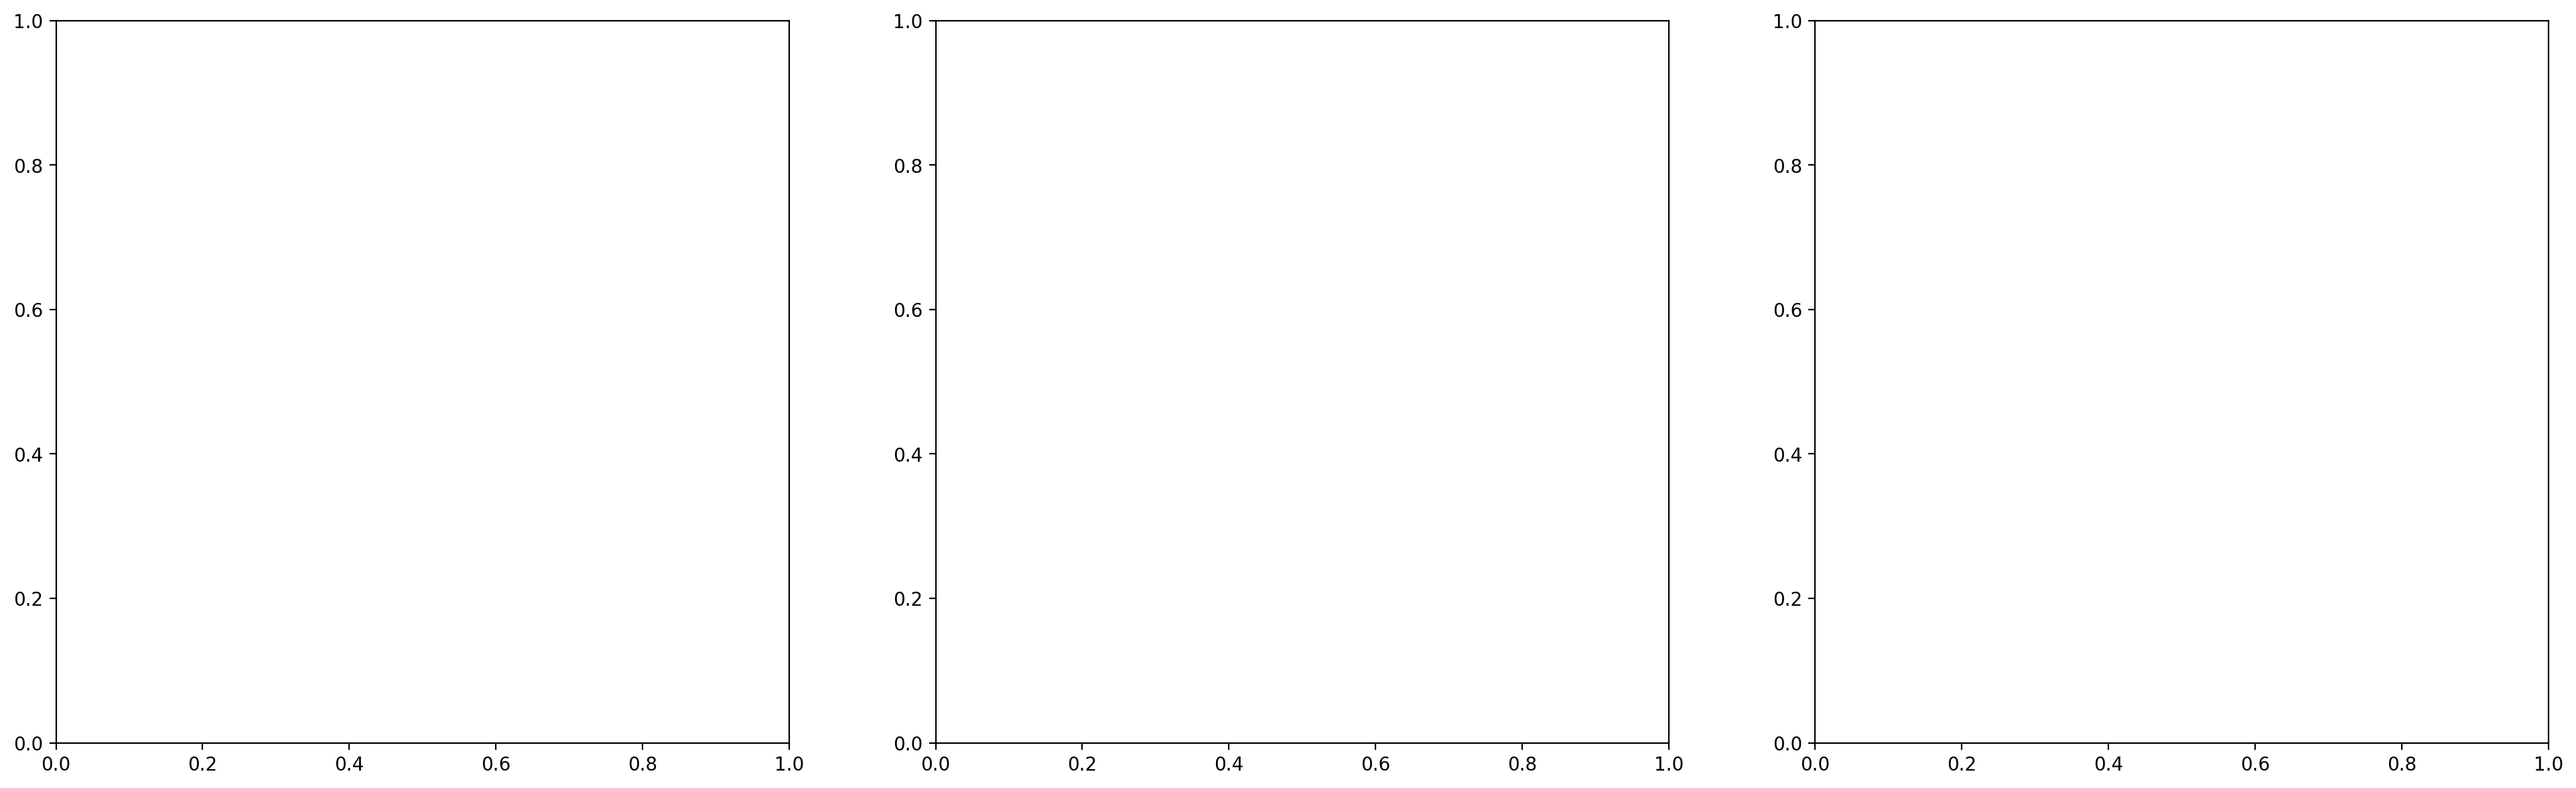

<Figure size 1000x600 with 0 Axes>

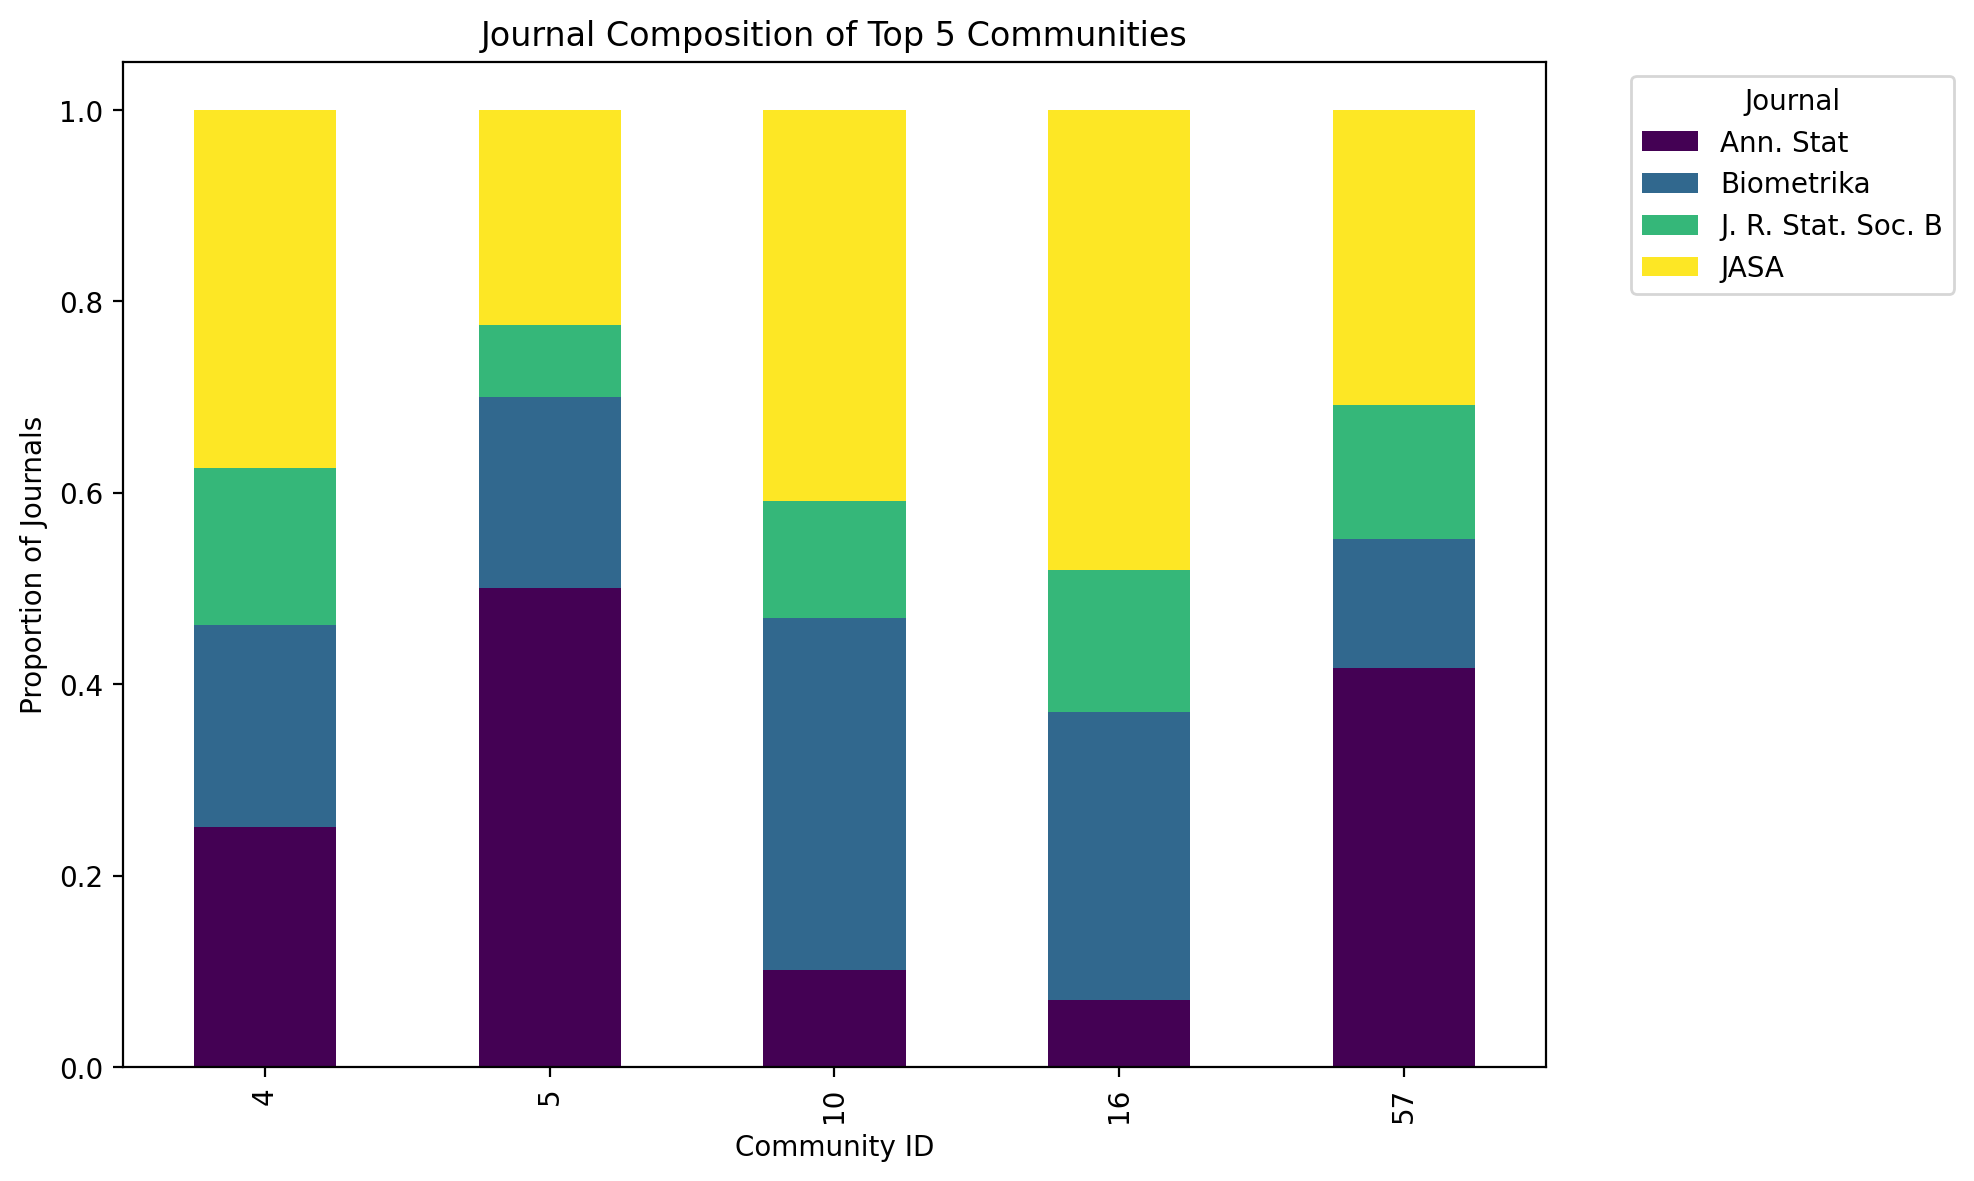


📉 NMI Score (Community vs. Journal): 0.0544
   Insight: Low NMI (<0.2) suggests communities are NOT split by Journal.
   This implies communities are likely formed by Research Topics rather than Journal boundaries.

🏷️ Topic Identification (Top Keywords per Community)
   Community 57 (Size: 497): [('lasso', 95), ('variable selection', 81), ('sparsity', 57), ('model selection', 48), ('oracle property', 29)]
   Community 10 (Size: 445): [('survival analysis', 38), ('quantile regression', 30), ('survival data', 24), ('em algorithm', 23), ('counting process', 22)]
   Community 5 (Size: 400): [('sparsity', 32), ('principal component analysis', 21), ('covariance matrix', 19), ('high-dimensional data', 18), ('regularization', 15)]
   Community 4 (Size: 398): [('functional data analysis', 78), ('longitudinal data', 39), ('functional data', 31), ('smoothing', 29), ('nonparametric regression', 26)]
   Community 16 (Size: 385): [('causal inference', 78), ('sensitivity analysis', 34), ('missing d

In [ ]:
# 7.1 Community Detection Implementation
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from collections import Counter

# --- 1. Configuration (配置层) ---
COMMUNITY_CONFIG = {
    'seed': 42,
    'top_n_display': 5,
    'plot': {
        'figsize': (10, 6),
        'colormap': 'viridis'
    }
}

# --- 2. Functional Core (逻辑层) ---
def build_graph_from_df(paper_info: pd.DataFrame, paper_citations: pd.DataFrame) -> nx.DiGraph:
    """
    Constructs a directed graph from dataframes, ensuring edge validity.
    """
    print("🏗️ Constructing Graph from cleaned data...")
    valid_ids = set(paper_info['paper_id'])
    
    # Filter edges where both source and target exist in the node list
    valid_edges = paper_citations[
        paper_citations['source'].isin(valid_ids) & 
        paper_citations['target'].isin(valid_ids)
    ]
    
    G = nx.from_pandas_edgelist(
        valid_edges, 
        source='source', 
        target='target', 
        create_using=nx.DiGraph()
    )
    print(f"   Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
    return G

def detect_communities_louvain(G: nx.Graph, seed: int = 42) -> dict:
    """
    Runs Louvain algorithm on the undirected version of the graph.
    Returns: dict {node_id: community_id}
    """
    G_undirected = G.to_undirected()
    print(f"🔍 Running Louvain Community Detection on {G_undirected.number_of_nodes()} nodes...")
    
    try:
        # Try networkx built-in (v2.7+)
        communities = nx.community.louvain_communities(G_undirected, seed=seed)
        partition = {}
        for idx, comm in enumerate(communities):
            for node in comm:
                partition[node] = idx
        print(f"   Detected {len(communities)} communities.")
        return partition
    except AttributeError:
        # Fallback for older networkx or python-louvain
        try:
            import community.community_louvain as community_louvain
            partition = community_louvain.best_partition(G_undirected, random_state=seed)
            print(f"   Detected {len(set(partition.values()))} communities (using python-louvain).")
            return partition
        except ImportError:
            print("   ❌ Error: Could not find Louvain implementation. Please upgrade networkx (>=2.7) or install python-louvain.")
            return {}

def analyze_communities(partition: dict, paper_info: pd.DataFrame, config: dict):
    """
    Analyzes and visualizes the composition of detected communities.
    """
    if not partition:
        return

    # Prepare DataFrame
    comm_df = pd.DataFrame(list(partition.items()), columns=['paper_id', 'community_id'])
    
    # Merge metadata
    cols_to_use = ['paper_id', 'publisher', 'title']
    if 'keywords' in paper_info.columns:
        cols_to_use.append('keywords')
    
    merged_df = comm_df.merge(paper_info[cols_to_use], on='paper_id', how='left')
    
    # Filter Top N Communities
    top_n = config['top_n_display']
    top_comm_ids = merged_df['community_id'].value_counts().head(top_n).index
    top_comm_df = merged_df[merged_df['community_id'].isin(top_comm_ids)]
    
    # 1. Journal Composition Analysis
    ct = pd.crosstab(top_comm_df['community_id'], top_comm_df['publisher'])
    print(f"\n📊 Community Composition by Journal (Top {top_n})")
    print(ct)
    
    # Visualization
    plt.figure(figsize=config['plot']['figsize'])
    ct_norm = ct.div(ct.sum(axis=1), axis=0) # Normalize by row
    ct_norm.plot(kind='bar', stacked=True, colormap=config['plot']['colormap'], figsize=config['plot']['figsize'])
    plt.title(f'Journal Composition of Top {top_n} Communities')
    plt.xlabel('Community ID')
    plt.ylabel('Proportion of Journals')
    plt.legend(title='Journal', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()
    
    # 2. NMI Score Analysis
    valid_comm_df = merged_df.dropna(subset=['publisher'])
    nmi = normalized_mutual_info_score(valid_comm_df['publisher'], valid_comm_df['community_id'])
    
    print(f"\n📉 NMI Score (Community vs. Journal): {nmi:.4f}")
    if nmi < 0.2:
        print("   Insight: Low NMI (<0.2) suggests communities are NOT split by Journal.")
        print("   This implies communities are likely formed by Research Topics rather than Journal boundaries.")
    else:
        print("   Insight: Higher NMI suggests some journals form their own isolated communities.")

    # 3. Topic Identification (Keywords)
    if 'keywords' in merged_df.columns:
        print(f"\n🏷️ Topic Identification (Top Keywords per Community)")
        for cid in top_comm_ids:
            subset = merged_df[merged_df['community_id'] == cid]
            all_kw = []
            for kw_str in subset['keywords'].dropna():
                # Split by comma or semicolon, strip whitespace
                keywords = [k.strip().lower() for k in str(kw_str).replace(';', ',').split(',')]
                all_kw.extend(keywords)
            
            if all_kw:
                common = Counter(all_kw).most_common(5)
                print(f"   Community {cid} (Size: {len(subset)}): {common}")
            else:
                print(f"   Community {cid}: No keywords found.")

# --- 3. Execution (执行层) ---
# Assuming paper_info and paper_citations are available from global context
if 'paper_info' in locals() and 'paper_citations' in locals():
    G_full = build_graph_from_df(paper_info, paper_citations)
    partition = detect_communities_louvain(G_full, seed=COMMUNITY_CONFIG['seed'])
    analyze_communities(partition, paper_info, COMMUNITY_CONFIG)
else:
    print("Error: Data not loaded. Please run the data loading cells first.")

## B. 权威识别
### 权威识别 vs. 链接预测 (Authority Identification vs. Link Prediction)

您提到的“必读清单”与“推荐系统”在本质上是有区别的，它们解决了两个不同层面的问题：

#### 1. 区别辨析

| 特性 | **权威识别 (Authority Identification)** | **链接预测 (Link Prediction)** |
| :--- | :--- | :--- |
| **本质** | **全局排名 (Global Ranking)** | **个性化推荐 (Personalized Recommendation)** |
| **类比** | **"豆瓣电影 Top 250"** | **"猜你喜欢" / "看了这部电影的人也看了..."** |
| **目标** | 寻找整个网络中最重要的基石文献。 | 为特定的论文/作者推荐可能遗漏的参考文献。 |
| **输入** | 整个网络结构。 | 局部网络结构 + 节点属性 (内容相似度)。 |
| **算法** | **HITS**, PageRank, Centrality. | Node2Vec, DeepWalk, Adamic-Adar Index. |
| **结果** | 一份静态的“必读清单” (所有人看到都一样)。 | 针对每篇论文定制的推荐列表 (千人千面)。 |

#### 2. 如何实现“必读清单” (HITS 算法)

我们将使用 **HITS (Hyperlink-Induced Topic Search)** 算法。它非常适合引文网络，因为它将节点定义为两种角色：
*   **Authority (权威)**: 被许多 Hub 引用的节点。代表**高质量的原创研究**（即我们要找的“必读清单”）。
*   **Hub (枢纽)**: 引用了许多 Authority 的节点。代表**高质量的综述**或**教科书式文章**。

**互强关系**: 一个好的 Authority 是被很多好的 Hub 指向的；一个好的 Hub 是指向很多好的 Authority 的。

下面的代码将计算每篇论文的 Authority Score，并生成统计学领域的“必读清单”。

Original edges: 23737
Edges within Big 4: 23709
Graph constructed with 5737 nodes and 23709 edges.

🏆 Top 10 Authorities (The 'Must-Read' List - High Impact Research):
                                                                           title          publisher  authority_score
Variable selection via nonconcave penalized likelihood and its oracle properties               JASA         0.055689
                                    The adaptive lasso and its oracle properties               JASA         0.039297
                                                          Least angle regression          Ann. Stat         0.026680
       The Dantzig selector: Statistical estimation when p is much larger than n          Ann. Stat         0.024354
                   High-dimensional graphs and variable selection with the Lasso          Ann. Stat         0.023842
             Sure independence screening for ultrahigh dimensional feature space J. R. Stat. Soc. B         0.023039
             

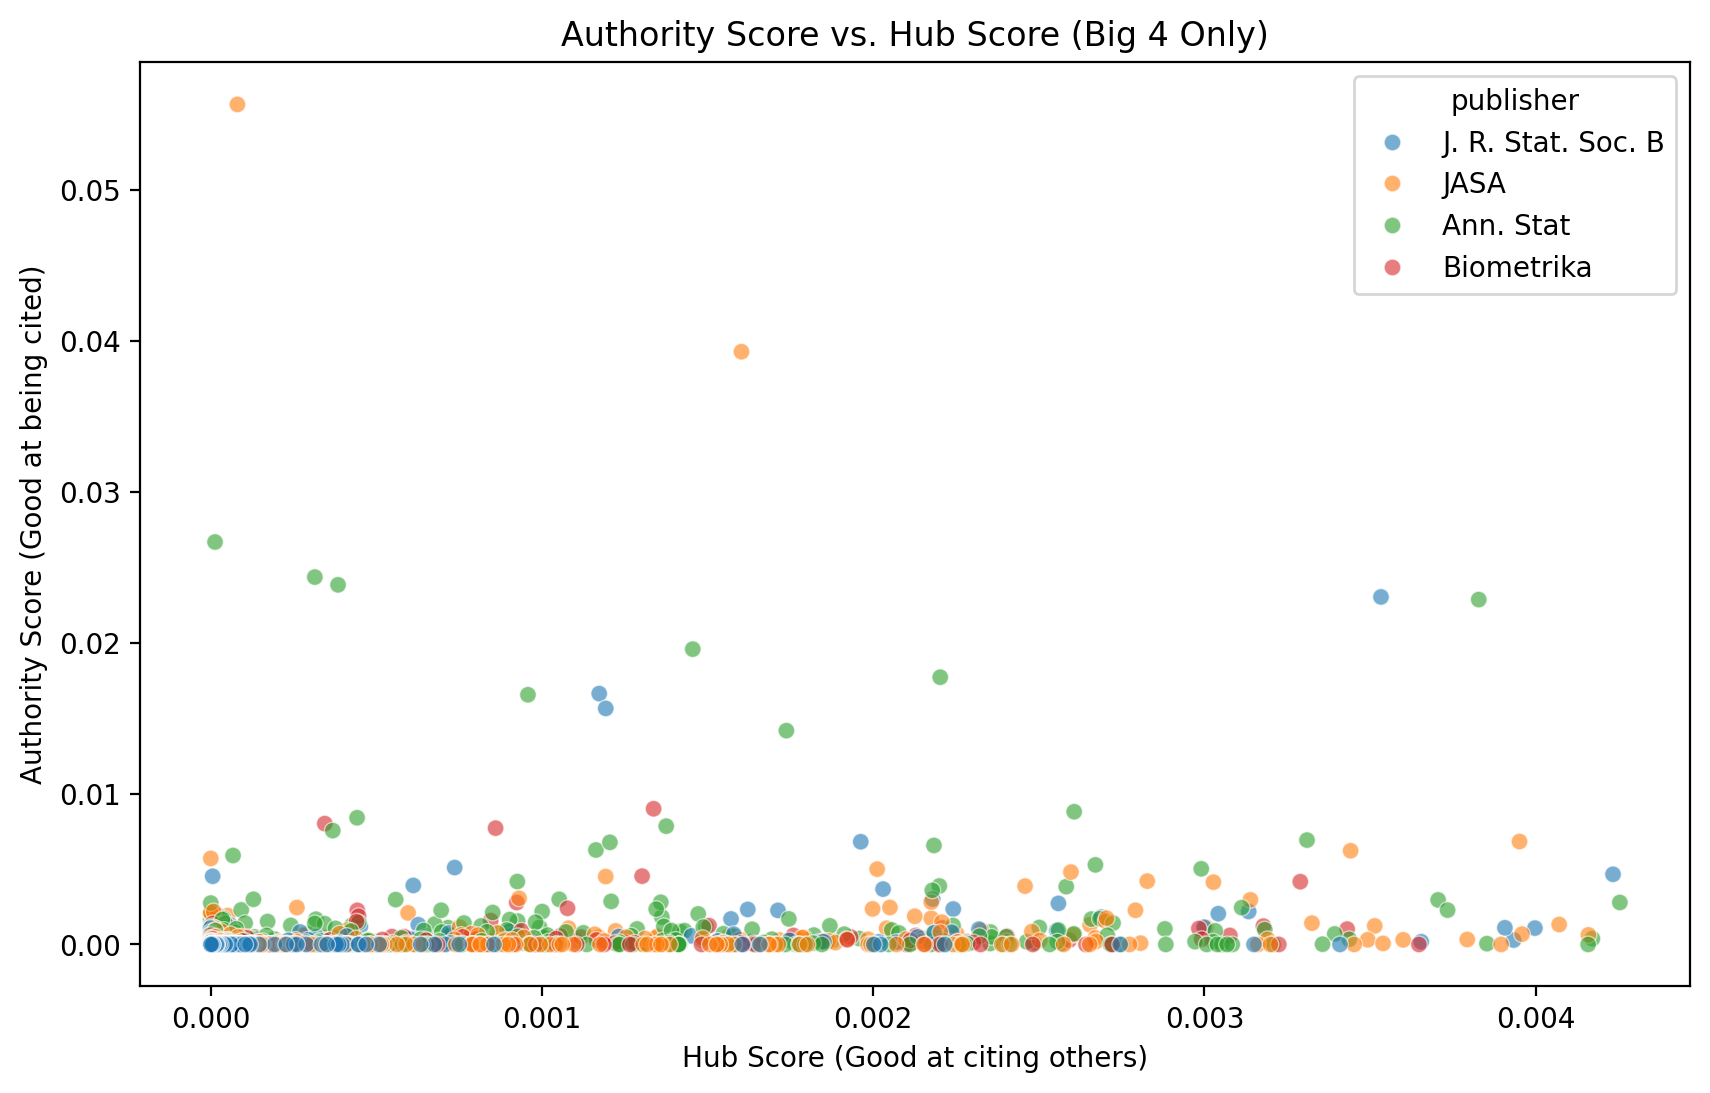


=== Comparison: HITS Authority vs. Raw Citation Counts ===
Top 10 Overlap: 9/10 papers match.
Top 50 Overlap: 28/50 papers match.

Insight: The 'Must-Read' list (HITS) is NOT identical to the 'Most Cited' list.
HITS identifies papers that are cited by *other important papers*, not just popular ones.

💎 Hidden Gems (High Authority but not in Top 10 Raw Citations):
                                                              title  authority_score
One-step sparse estimates in nonconcave penalized likelihood models         0.017717


In [ ]:
# 5.1 HITS Algorithm Implementation
# Calculate Hubs and Authorities scores to identify "Must-Read" papers

# 1. Construct the graph using ONLY Big 4 papers (Cleaned Data)
# Filter edges where both source and target are in our cleaned paper_info
valid_ids = set(paper_info['paper_id'])
cleaned_citations = paper_citations[
    paper_citations['source'].isin(valid_ids) & 
    paper_citations['target'].isin(valid_ids)
]

print(f"Original edges: {len(paper_citations)}")
print(f"Edges within Big 4: {len(cleaned_citations)}")

G_full = nx.from_pandas_edgelist(
    cleaned_citations, 
    source='source', 
    target='target', 
    create_using=nx.DiGraph()
)

print(f"Graph constructed with {G_full.number_of_nodes()} nodes and {G_full.number_of_edges()} edges.")

# 2. Run HITS Algorithm
try:
    # max_iter=1000 to ensure convergence
    hubs, authorities = nx.hits(G_full, max_iter=1000, normalized=True)
    
    # 3. Process Results
    # Convert to DataFrame
    auth_df = pd.DataFrame(list(authorities.items()), columns=['paper_id', 'authority_score'])
    hub_df = pd.DataFrame(list(hubs.items()), columns=['paper_id', 'hub_score'])
    
    # Merge with paper info to get titles and journals
    # Check if 'year' exists (it might be created in a later cell)
    cols_to_use = ['paper_id', 'title', 'publisher']
    if 'year' in paper_info.columns:
        cols_to_use.append('year')

    auth_df = auth_df.merge(paper_info[cols_to_use], on='paper_id', how='left')
    hub_df = hub_df.merge(paper_info[cols_to_use], on='paper_id', how='left')
    
    # Sort by score
    top_authorities = auth_df.sort_values('authority_score', ascending=False).head(10)
    top_hubs = hub_df.sort_values('hub_score', ascending=False).head(10)
    
    # 4. Display "Must-Read List" (Top Authorities)
    print("\n🏆 Top 10 Authorities (The 'Must-Read' List - High Impact Research):")
    # Format for display
    display_cols_auth = ['title', 'publisher', 'authority_score']
    if 'year' in auth_df.columns:
        display_cols_auth.insert(2, 'year')
    print(top_authorities[display_cols_auth].to_string(index=False))
    
    # 5. Display "Top Reviewers/Connectors" (Top Hubs)
    print("\n🔗 Top 10 Hubs (The 'Best Connectors' - Reviews/Broad Citations):")
    display_cols_hub = ['title', 'publisher', 'hub_score']
    if 'year' in hub_df.columns:
        display_cols_hub.insert(2, 'year')
    print(top_hubs[display_cols_hub].to_string(index=False))
    
    # 6. Visualization: Authority vs Hub Score
    # Are authorities also hubs? (Usually no)
    merged_scores = auth_df.merge(hub_df[['paper_id', 'hub_score']], on='paper_id')
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='hub_score', y='authority_score', data=merged_scores, alpha=0.6, hue='publisher')
    plt.title('Authority Score vs. Hub Score (Big 4 Only)')
    plt.xlabel('Hub Score (Good at citing others)')
    plt.ylabel('Authority Score (Good at being cited)')
    plt.show()

    # ==========================================
    # 7. Comparison: Authority vs. Most Cited
    # ==========================================
    print("\n=== Comparison: HITS Authority vs. Raw Citation Counts ===")
    
    # Get Top 10 and Top 50 Most Cited (using cleaned citations)
    citation_counts_check = cleaned_citations['target'].value_counts().reset_index()
    citation_counts_check.columns = ['paper_id', 'citations']
    
    top_10_cited_ids = set(citation_counts_check.head(10)['paper_id'])
    top_50_cited_ids = set(citation_counts_check.head(50)['paper_id'])
    
    top_10_auth_ids = set(auth_df.sort_values('authority_score', ascending=False).head(10)['paper_id'])
    top_50_auth_ids = set(auth_df.sort_values('authority_score', ascending=False).head(50)['paper_id'])
    
    # Calculate Overlap
    overlap_10 = top_10_cited_ids.intersection(top_10_auth_ids)
    overlap_50 = top_50_cited_ids.intersection(top_50_auth_ids)
    
    print(f"Top 10 Overlap: {len(overlap_10)}/10 papers match.")
    print(f"Top 50 Overlap: {len(overlap_50)}/50 papers match.")
    
    if len(overlap_10) < 10:
        print("\nInsight: The 'Must-Read' list (HITS) is NOT identical to the 'Most Cited' list.")
        print("HITS identifies papers that are cited by *other important papers*, not just popular ones.")
        
        # Show papers that are in Top 10 Authority but NOT in Top 10 Cited (Hidden Gems)
        hidden_gems_ids = top_10_auth_ids - top_10_cited_ids
        if hidden_gems_ids:
            print("\n💎 Hidden Gems (High Authority but not in Top 10 Raw Citations):")
            hidden_gems = auth_df[auth_df['paper_id'].isin(hidden_gems_ids)]
            print(hidden_gems[['title', 'authority_score']].to_string(index=False))

except nx.PowerIterationFailedConvergence:
    print("HITS algorithm failed to converge. The graph might be too sparse or disconnected.")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

明显的 L 型分布 (或者说反比关系趋势)：

左上角 (High Authority, Low Hub)：这是图中最引人注目的几个点（Annals of Statistics, JASA 等刊物的点）。这些论文极少引用别人（相对于它们被引用的次数而言），但被大量引用。它们是纯粹的知识创造者。
右下角 (Low Authority, High Hub)：X轴右侧有很多点，Y轴数值很低。这些论文引用了大量的文献，但自身可能没有提出太多原创性的重磅理论，因此被引次数相对较少。
稀缺的“双高”节点：图中几乎没有点出现在右上角（既高 Authority 又高 Hub）。这意味着在学术界，很少有一篇文章既是开创性的理论鼻祖，同时又是包罗万象的超级综述。论文的功能通常比较单一：要么负责创新（Authority），要么负责总结（Hub）。

## C. 期刊交互 (Journal Interaction)

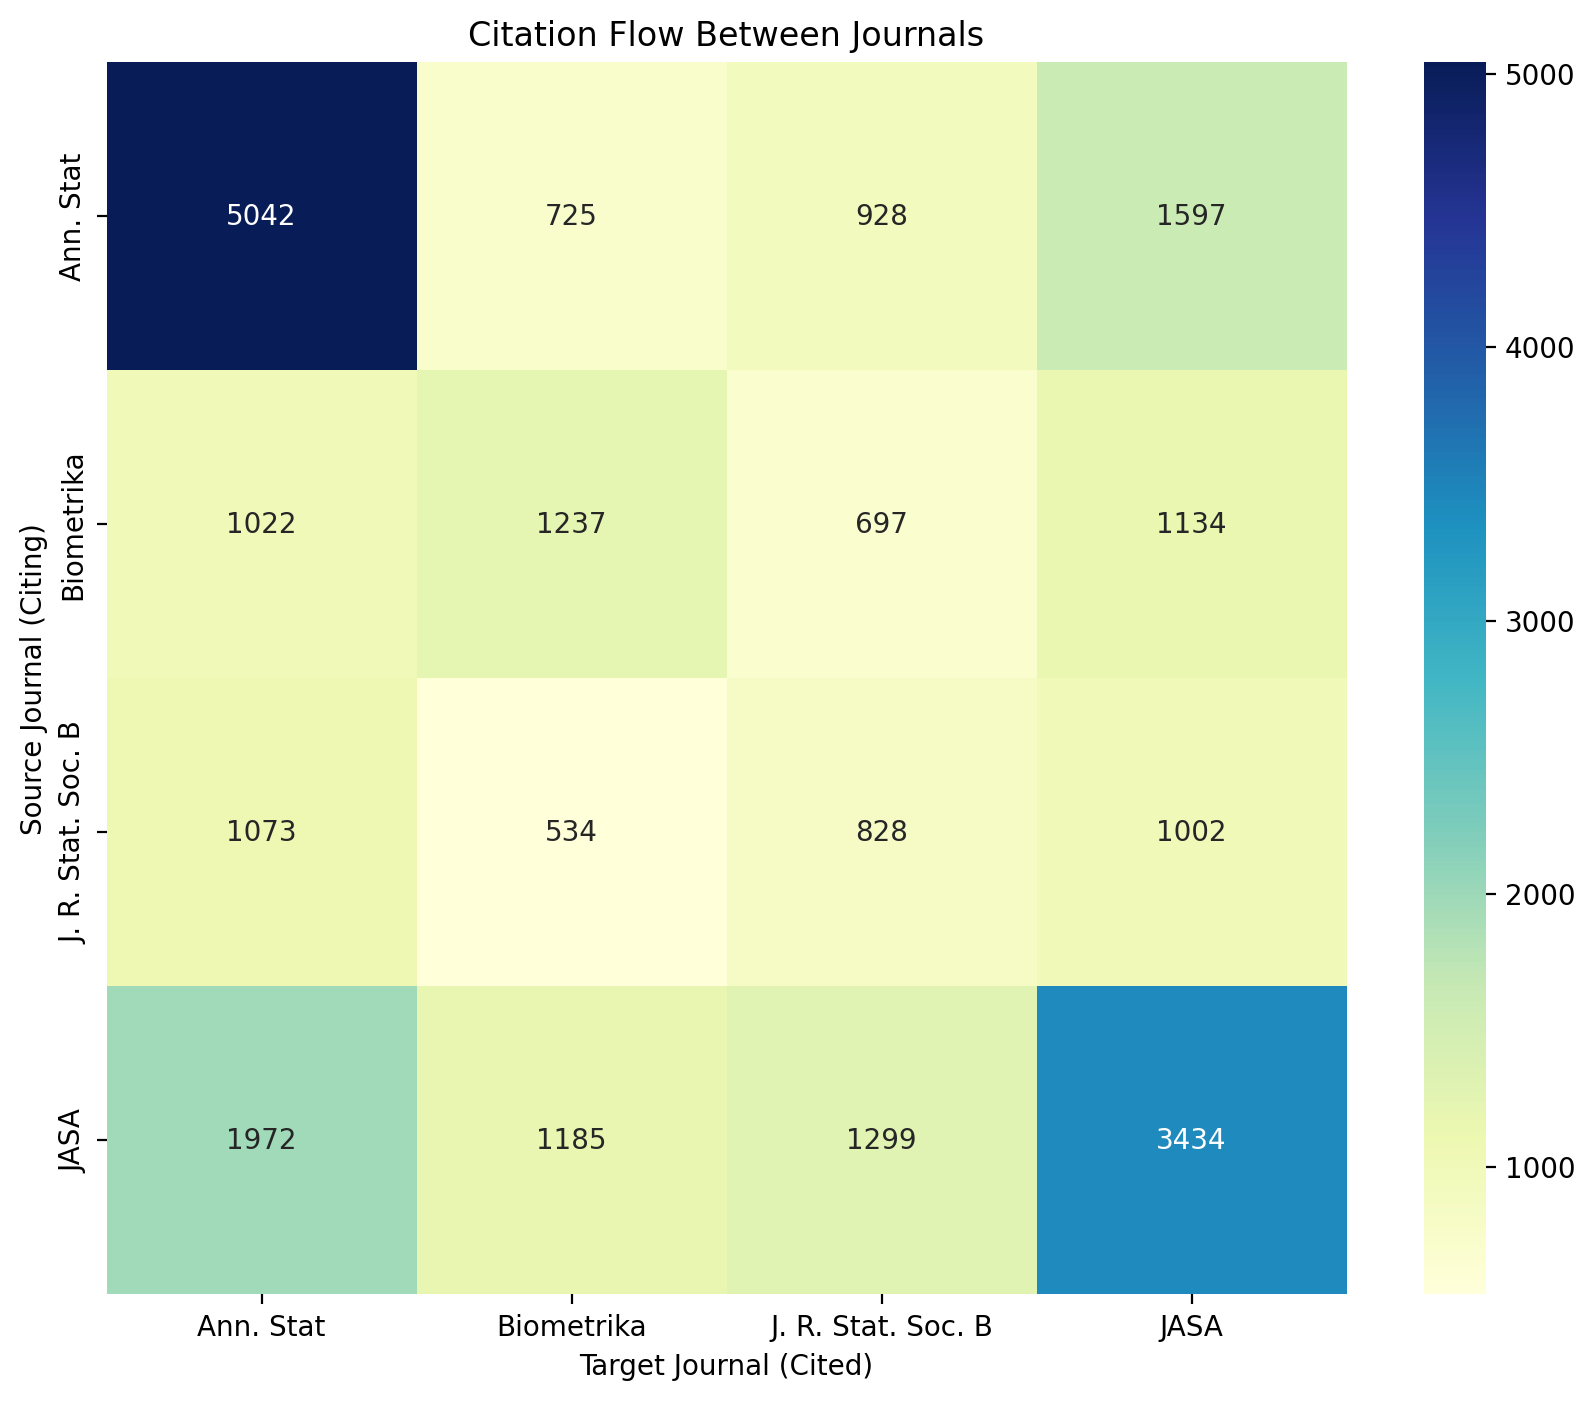

In [ ]:
# 4. Journal Citation Heatmap
# Analyze how journals cite each other
# Merge source journal
merged_citations = paper_citations.merge(paper_info[['paper_id', 'publisher']], left_on='source', right_on='paper_id', how='left')
merged_citations.rename(columns={'publisher': 'source_journal'}, inplace=True)

# Merge target journal
merged_citations = merged_citations.merge(paper_info[['paper_id', 'publisher']], left_on='target', right_on='paper_id', how='left')
merged_citations.rename(columns={'publisher': 'target_journal'}, inplace=True)

# Create pivot table
heatmap_data = pd.crosstab(merged_citations['source_journal'], merged_citations['target_journal'])

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Citation Flow Between Journals')
plt.ylabel('Source Journal (Citing)')
plt.xlabel('Target Journal (Cited)')
plt.show()

## C. Citation Flow Heatmap Interpretation

本节通过三种视角揭示期刊间的学术交互模式, 展示了四大期刊之间的相互引用流量, 是理解统计学界知识传播与影响力分布的关键。

### 1. 图表阅读指南 (How to Read)

| 视角 (View) | 归一化方式 (Normalization) | 核心含义 (Meaning) | 典型问题 (Question Answered) |
| :--- | :--- | :--- | :--- |
| **A. 绝对流量**<br>(Absolute Flow) | 无 (Raw Counts) | 引用次数 | 哪两个期刊之间的交互总量最大？ |
| **B. 引用偏好**<br>(Citation Preference) | **行归一化** (Row Normalized)<br>$\frac{Cell}{RowSum}$ | **输出视角**：某期刊发出的引用中，各目标期刊的占比。展示出应用依赖和认可度偏好特征, 体现期刊品味或关注点。 | *"JASA 的作者更喜欢引用谁？"* |
| **C. 影响力构成**<br>(Impact Composition) | **列归一化** (Column Normalized)<br>$\frac{Cell}{ColSum}$ | **输入视角**：某期刊收到的引用中，各来源期刊的占比。 | *"Ann. Stat 的影响力主要来自哪里？"* |

> **关键模式**:
> *   **对角线 (Diagonal)**: **自引率 (Self-Citation)**。数值越高，说明该期刊学术圈子越封闭（内卷）；数值越低，说明越开放。
> *   **非对角线 (Off-Diagonal)**: **知识流动 (Knowledge Flow)**。揭示了理论输出（上游）与应用采纳（下游）的关系。
> > 横向看 (Row)*: 观察某期刊主要参考了谁。例如，看 `Biometrika` 这一行，哪一列数值最高，就说明 `Biometrika` 最推崇哪个期刊的工作。  
> > 纵向看 (Column)*: 观察某期刊主要影响了谁。例如，看 `Ann. Stat` 这一列，哪一行数值最高，说明 `Ann. Stat` 对哪个期刊的影响力最大。


    
---

### 2. 核心发现与期刊画像 (Key Insights)

为了消除**期刊发文量不同**带来的规模偏差 (Size Bias)， 通过对比归一化热力图，我们发现统计学界存在明显的**层级结构**与**功能分化**：

| 期刊 | 角色定位 | 引用行为特征 (Outflow/Preference) | 影响力来源特征 (Inflow/Composition) |
| :--- | :--- | :--- | :--- |
| **Ann. Stat** | **理论孤岛 (Theoretical Core)** | **相对封闭**：60.8% 的引用指向自己，对他刊引用极少。 | **回音室效应**：55.4% 的被引来自自家作者。它是封闭的理论源头。 |
| **JASA** | **超级枢纽 (Super Hub)** | **博采众长**：引用分布最均衡，广泛吸收各方知识。 | **流量输出者**：由于发文量巨大，它是 Biometrika (32%) 和 JRSS-B (34%) 的最大引用来源。 |
| **JRSS-B** | **理论崇拜者 (Theory Follower)** | **仰视权威**：对 Ann. Stat 的引用 (31%) 甚至超过了自引 (24%)。 | **承上启下**：影响力主要来自 JASA 和 Ann. Stat 的混合。 |
| **Biometrika** | **中间派 (The Balancer)** | **均衡发展**：自引率适中，对 JASA 和 Ann. Stat 均有稳定关注。 | **主流认可**：引用构成与 JRSS-B 相似，是连接理论与应用的桥梁。 |

---

### 3. 对后续任务的启示 (Implications)

*   **社区发现 (Community Detection)**:
    *   预期 **Ann. Stat** 将形成一个紧密的理论导向的核心子社区(Core)。
    *   **JASA** 扮演枢纽(Hub)角色将作为连接各社区的桥梁（Bridge），维持全网连通性。
*   **层级关系 (Hierarchy)**:
    *   存在明显的**知识流动方向**：存在一个隐性的“引用层级”：JRSS-B 高度依赖 Ann. Stat（理论上游），而 JASA 则广泛引用所有期刊（应用与综述下游）。
*   **链接预测 (Link Prediction)**:
    *   **期刊同质性 (Homophily)** 是强特征：两篇 Ann. Stat 文章产生链接的概率远高于跨刊链接。
    *   **非对称依赖**：预测 JRSS-B 引用 Ann. Stat 的概率应赋予高权重（尽管反之不成立）。
*   **结构洞 (Structural Holes)**:
    *   机会在于 **Ann. Stat (纯理论)** 与 **JASA (综合应用)** 之间。寻找那些同时被这两本刊高频引用的“双栖”作者，他们可能是跨越理论与应用鸿沟的关键人物。

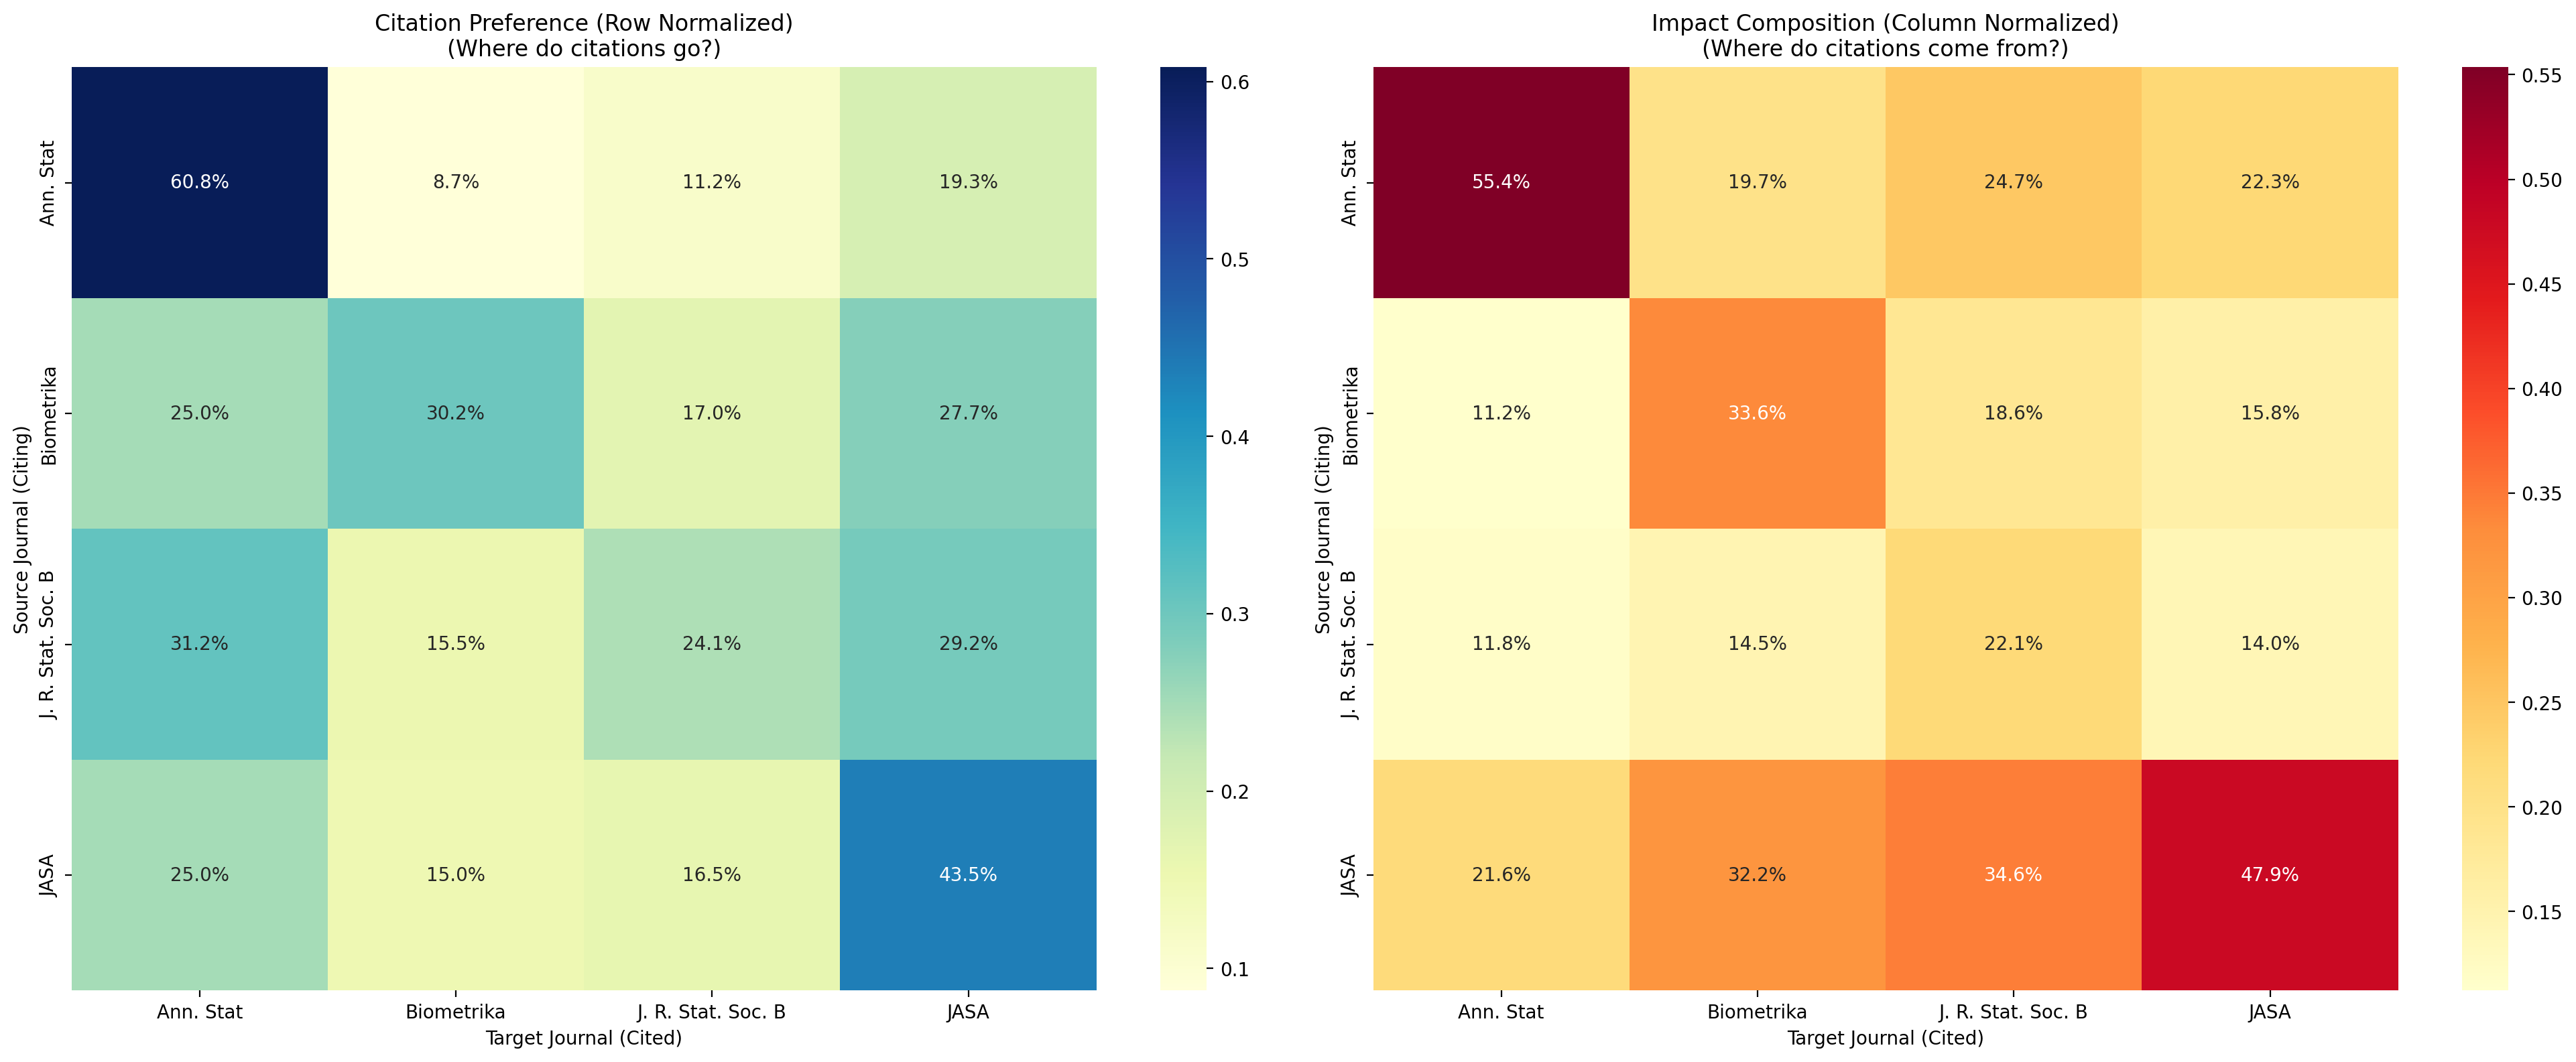

In [ ]:
# 4.1 Normalized Heatmaps (Size Bias Correction)
# To address the "Size Bias" (some journals publish more papers), we normalize the citation counts.

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Row Normalization: Citation Preference (Outflow)
# "When a journal cites, who do they cite?"
# Divide each row by the row sum
heatmap_row_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

sns.heatmap(heatmap_row_norm, annot=True, fmt='.1%', cmap='YlGnBu', ax=axes[0])
axes[0].set_title('Citation Preference (Row Normalized)\n(Where do citations go?)')
axes[0].set_ylabel('Source Journal (Citing)')
axes[0].set_xlabel('Target Journal (Cited)')

# 2. Column Normalization: Impact Composition (Inflow)
# "When a journal is cited, who is citing them?"
# Divide each column by the column sum
heatmap_col_norm = heatmap_data.div(heatmap_data.sum(axis=0), axis=1)

sns.heatmap(heatmap_col_norm, annot=True, fmt='.1%', cmap='YlOrRd', ax=axes[1])
axes[1].set_title('Impact Composition (Column Normalized)\n(Where do citations come from?)')
axes[1].set_ylabel('Source Journal (Citing)')
axes[1].set_xlabel('Target Journal (Cited)')

plt.tight_layout()
plt.show()

### C. 假设检验与显著性分析 (Hypothesis Testing & Significance)

为了验证上述热力图中的“偏好”是否具有统计学显著性（即排除随机波动的影响），我们引入 **卡方独立性检验 (Chi-square Test of Independence)** 和 **标准化残差分析 (Standardized Residuals Analysis)**。

#### 1. 理论框架 (Theoretical Framework)
我们将引用矩阵视为一个 **列联表 (Contingency Table)**。
*   **零假设 ($H_0$)**: 期刊之间的引用是随机的，仅取决于期刊的体量（发文量/总被引量）。即“引用方”与“被引方”是独立的。
    *   期望频数 ($E_{ij}$) = $\frac{(\text{Row Total}_i) \times (\text{Column Total}_j)}{\text{Grand Total}}$
*   **备择假设 ($H_1$)**: 引用行为存在显著的结构性偏好（Homophily 或 Heterophily）。

#### 2. 统计量与置信水平 (Statistics & Confidence Level)
我们计算 **标准化皮尔逊残差 (Standardized Pearson Residuals)** 来衡量观测值与期望值的偏离程度：
$$ Z_{ij} \approx \frac{O_{ij} - E_{ij}}{\sqrt{E_{ij}}} $$

*   **判据 (基于正态分布近似)**:
    *   若 $Z_{ij} > 1.96$ (对应 **95% 置信水平**, $\alpha=0.05$): 表示 **显著的过度引用 (Over-citation)**，即存在强偏好。
    *   若 $Z_{ij} < -1.96$: 表示 **显著的引用回避 (Under-citation)**。
    *   若 $Z_{ij} > 2.58$ (对应 **99% 置信水平**, $\alpha=0.01$): 极显著。

通过这种方法，我们可以从统计学角度断言：“JASA 对 Annals 的引用显著低于预期”，而不仅仅是看百分比的大小。

=== Chi-square Test Results ===
Chi-square Statistic: 3575.79
P-value: 0.0000e+00
Degrees of Freedom: 9

Conclusion: Reject Null Hypothesis (p < 0.05).
The citation behavior is NOT random. There are statistically significant preferences between journals.


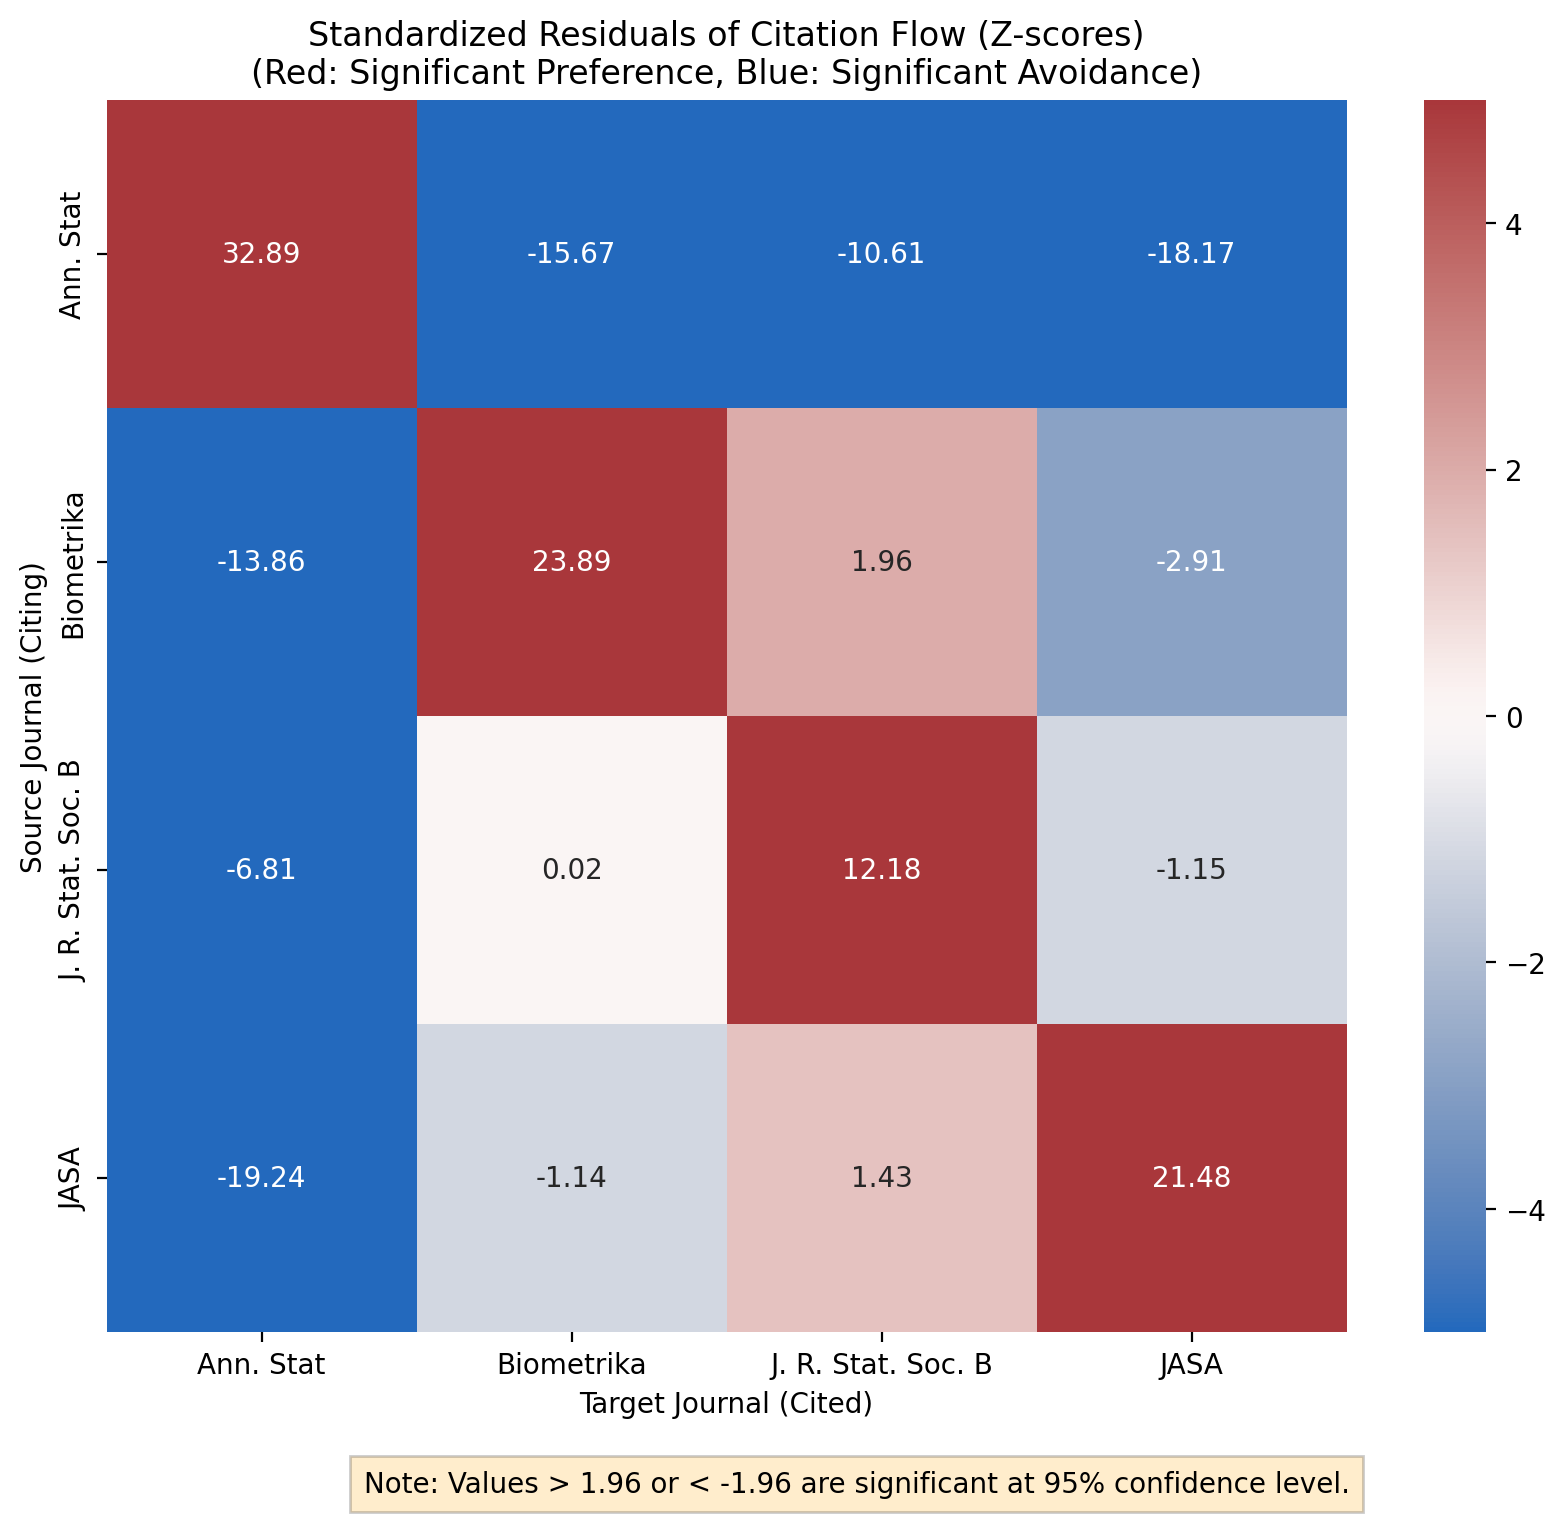

In [ ]:
# 4.2 Statistical Significance Test (Chi-square & Residuals)
from scipy.stats import chi2_contingency

# 1. Perform Chi-square test of independence
# H0: The source and target journals are independent (no specific preference)
chi2, p, dof, expected = chi2_contingency(heatmap_data)

print("=== Chi-square Test Results ===")
print(f"Chi-square Statistic: {chi2:.2f}")
print(f"P-value: {p:.4e}")
print(f"Degrees of Freedom: {dof}")

if p < 0.05:
    print("\nConclusion: Reject Null Hypothesis (p < 0.05).")
    print("The citation behavior is NOT random. There are statistically significant preferences between journals.")
else:
    print("\nConclusion: Accept Null Hypothesis.")
    print("No significant preferences found.")

# 2. Calculate Standardized Residuals (Z-scores)
# Formula: (Observed - Expected) / sqrt(Expected)
# This tells us WHICH specific cells are contributing to the non-randomness
observed = heatmap_data.values
residuals = (observed - expected) / np.sqrt(expected)

# Convert to DataFrame for plotting
residuals_df = pd.DataFrame(residuals, index=heatmap_data.index, columns=heatmap_data.columns)

# 3. Visualize Residuals
plt.figure(figsize=(10, 8))
# Use a diverging colormap (Red = More than expected, Blue = Less than expected)
# Center at 0. Range +/- 3 covers most significant values (Z > 1.96 is significant at 95% confidence)
sns.heatmap(residuals_df, annot=True, fmt='.2f', cmap='vlag', center=0, vmin=-5, vmax=5)

plt.title('Standardized Residuals of Citation Flow (Z-scores)\n(Red: Significant Preference, Blue: Significant Avoidance)')
plt.ylabel('Source Journal (Citing)')
plt.xlabel('Target Journal (Cited)')

# Add a note about significance threshold
plt.figtext(0.5, 0.01, "Note: Values > 1.96 or < -1.96 are significant at 95% confidence level.", ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

plt.show()

## D. 链接预测 (Link Prediction)
### D. 链接预测与论文推荐 (Link Prediction & Recommendation)

基于 **Graph Embedding (图嵌入)** 技术，我们将网络中的每个节点（论文）映射为一个低维向量。
*   **核心思想**: 在网络中结构相似或距离相近的节点，其向量表示也应该相近。
*   **方法**: 使用 **Node2Vec** 算法（基于随机游走）。
*   **应用**: 计算向量间的 **余弦相似度 (Cosine Similarity)**，如果两篇论文相似度很高但尚未引用，系统将推荐建立引用关系。

In [1]:
# 6.1 Link Prediction using Node2Vec

import warnings
warnings.filterwarnings('ignore') # Suppress warnings for cleaner output

try:
    from node2vec import Node2Vec
    from gensim.models import Word2Vec
    import gensim
    
    print(f"Gensim version: {gensim.__version__}")
    print("Training Node2Vec model... (This may take a while)")
    
    # 1. Initialize Node2Vec (Generates Random Walks)
    # dimensions: vector size (64 is a good balance for this graph size)
    # walk_length: length of random walk
    # num_walks: number of walks per node
    # workers: parallel threads (set to 1 for stability in some envs)
    # Note: We don't use node2vec.fit() to avoid gensim version compatibility issues
    node2vec_obj = Node2Vec(G_full, dimensions=64, walk_length=10, num_walks=10, workers=1, quiet=True)
    
    # 2. Train Word2Vec Model manually
    # Ensure walks are list of strings
    walks = [[str(node) for node in walk] for walk in node2vec_obj.walks]
    
    # Handle gensim 4.0.0+ API change (size -> vector_size)
    if gensim.__version__ >= '4.0.0':
        model = Word2Vec(sentences=walks, vector_size=64, window=10, min_count=1, workers=1, sg=1)
    else:
        model = Word2Vec(sentences=walks, size=64, window=10, min_count=1, workers=1, sg=1)
        
    print("Model training complete.")
    
    # 3. Define Recommendation Function
    def recommend_citations(paper_id, top_k=5):
        str_id = str(paper_id)
        # Check if node exists in the model
        if str_id not in model.wv:
            return None
            
        # Get most similar nodes (returns list of (id, score))
        # We ask for more than top_k because we need to filter existing edges
        potential_links = model.wv.most_similar(str_id, topn=top_k*20)
        
        # Get existing citations to filter them out
        # G_full is the graph we used
        if paper_id in G_full:
            existing_citations = set(G_full.successors(paper_id))
        else:
            existing_citations = set()
        
        recommendations = []
        for neighbor_id_str, score in potential_links:
            try:
                neighbor_id = int(neighbor_id_str)
            except ValueError:
                continue # Skip if not integer id
                
            # Filter: Not self, and not already cited
            if neighbor_id not in existing_citations and neighbor_id != paper_id:
                recommendations.append({'paper_id': neighbor_id, 'similarity': score})
                if len(recommendations) >= top_k:
                    break
        
        if not recommendations:
            return pd.DataFrame()
            
        rec_df = pd.DataFrame(recommendations)
        # Merge with metadata for readability
        cols_to_use = ['paper_id', 'title', 'publisher']
        if 'year' in paper_info.columns:
            cols_to_use.append('year')
            
        rec_df = rec_df.merge(paper_info[cols_to_use], on='paper_id', how='left')
        return rec_df

    # 4. Demo: Recommend for a Top Authority Paper
    # Let's pick the top 1 authority from previous step
    if 'top_authorities' in locals() and not top_authorities.empty:
        target_paper = top_authorities.iloc[0]
        pid = target_paper['paper_id']
        title = target_paper['title']
        
        print(f"\n📚 Generating Recommendations for: [{pid}] {title[:50]}...")
        recs = recommend_citations(pid, top_k=5)
        
        if recs is not None and not recs.empty:
            print("\n💡 Recommended Citations (Potential Missing Links):")
            display_cols = ['similarity', 'title', 'publisher']
            if 'year' in recs.columns:
                display_cols.append('year')
            print(recs[display_cols].to_string(index=False))
        else:
            print("No recommendations found.")
            
except ImportError:
    print("Error: 'node2vec' library not found.")
    print("Please run: !pip install node2vec")
    print("Or use the terminal to install it.")
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()

Error: 'node2vec' library not found.
Please run: !pip install node2vec
Or use the terminal to install it.


## 2.2.5 Temporal Concentration of Citations

Line plot showing the Gini coefficient of citations over time (where year data is available). This tracks how unequal citation distributions are across years, indicating whether citation concentration has increased or decreased over the study period.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Function to calculate Gini coefficient
def gini_coefficient(x):
    """
    Calculate Gini coefficient (measure of inequality).
    Gini = 1 means perfect inequality, Gini = 0 means perfect equality.
    """
    x = np.array(x)
    x = x[~np.isnan(x)]  # Remove NaN values
    if len(x) == 0:
        return np.nan
    
    sorted_x = np.sort(x)
    n = len(sorted_x)
    cumsum = np.cumsum(sorted_x)
    
    # Gini coefficient formula
    gini = (2 * np.sum((np.arange(1, n+1)) * sorted_x)) / (n * np.sum(sorted_x)) - (n + 1) / n
    return gini

# Calculate Gini coefficient for each year
if 'year' in paper_info.columns and paper_info['year'].notna().any():
    gini_by_year = {}
    years = sorted(paper_info['year'].dropna().unique())
    
    for year in years:
        year_papers = paper_info[paper_info['year'] == year]['paper_id'].tolist()
        year_citations = paper_citations[paper_citations['target'].isin(year_papers)]
        citation_counts = year_citations['target'].value_counts().values
        
        if len(citation_counts) > 0:
            gini = gini_coefficient(citation_counts)
            gini_by_year[year] = gini
    
    # Plot
    if gini_by_year:
        years_plot = sorted(gini_by_year.keys())
        gini_values = [gini_by_year[y] for y in years_plot]
        
        plt.figure(figsize=(12, 6))
        plt.plot(years_plot, gini_values, marker='o', linewidth=2, markersize=6, color='#2C7FB8')
        plt.xlabel('Year', fontsize=12)
        plt.ylabel('Gini Coefficient', fontsize=12)
        plt.title('Citation Concentration (Gini Coefficient) Over Time', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("Gini Coefficient by Year:")
        for year in years_plot:
            print(f"  {int(year)}: {gini_by_year[year]:.4f}")
    else:
        print("No citation data available for years in the dataset.")
else:
    print("Year information not available in dataset.")

NameError: name 'paper_info' is not defined